In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess data
df = pd.read_csv(r"Eight_Class_Dataset.csv").dropna()
target_col = 'Attack_type'
label_names = sorted(df[target_col].unique())
label_mapping = {name: idx for idx, name in enumerate(label_names)}
df[target_col] = df[target_col].map(label_mapping)

# PyTorch Dataset
class DynamicDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features.astype('float32')
        self.y = labels.astype('int64')
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create DataLoaders
def create_loaders(train, val, test, batch_size=32):
    return (
        DataLoader(train, batch_size=batch_size, shuffle=True),
        DataLoader(val, batch_size=batch_size, shuffle=False),
        DataLoader(test, batch_size=batch_size, shuffle=False),
    )

# DNN Architectures
class DynamicDNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DynamicDNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)

class CustomDNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomDNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize models
model = DynamicDNN(df.shape[1] - 1, len(label_names))
custom_model = CustomDNN(df.shape[1] - 1, len(label_names))
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Accumulate training loss and accuracy
            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                # Accumulate validation loss and accuracy
                val_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        # Calculate average loss and accuracy for the epoch
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics
        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)
        metrics['train_acc'].append(train_acc)
        metrics['val_acc'].append(val_acc)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return metrics

# Plot metrics
def plot_metrics(metrics, filename_prefix):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.title(f'{filename_prefix}: Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['val_acc'], label='Validation Accuracy')
    plt.title(f'{filename_prefix}: Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"{filename_prefix}_loss_accuracy_curves.png")
    plt.show()
    plt.clf()

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    return all_preds, all_labels

# Generate reports
def generate_report(y_true, y_pred, labels, filename_prefix):
# Dynamically filter labels based on the classes present in y_true
    # Dynamically filter labels based on the classes present in y_true
    unique_classes = sorted(np.unique(y_true))
    filtered_labels = [labels[i] for i in unique_classes]

    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=unique_classes, target_names=filtered_labels))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_labels, yticklabels=filtered_labels)
    plt.title(f'{filename_prefix}: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()
    
    # Save the confusion matrix
    plt.savefig(f"{filename_prefix}_confusion_matrix.png")
    plt.show()
    plt.clf()

# Logistic Regression with SGD
sgd_model = SGDClassifier(loss='log_loss', max_iter=1, learning_rate='constant', eta0=0.01, random_state=42, warm_start=True)

def train_sgd_model(X_train, y_train, X_val, y_val, epochs=20):
    train_accs, val_accs = [], []
    for epoch in range(epochs):
        sgd_model.fit(X_train, y_train)
        train_acc = sgd_model.score(X_train, y_train)
        val_acc = sgd_model.score(X_val, y_val)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    return train_accs, val_accs

# Run experiments
def run_experiment(filtered_df, filename_prefix, learning_rates=None, batch_sizes=None):
    X = filtered_df.drop(target_col, axis=1)
    y = filtered_df[target_col]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    train_dataset = DynamicDataset(X_train_scaled, y_train.values)
    val_dataset = DynamicDataset(X_val_scaled, y_val.values)
    test_dataset = DynamicDataset(X_test_scaled, y_test.values)

    # Gradient Boosting
    print("\n--- Gradient Boosting ---")
    gb_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, random_state=42)
    gb_model.fit(X_train_scaled, y_train)
    gb_preds = gb_model.predict(X_test_scaled)
    # Generate confusion matrix and classification report for Gradient Boosting
    generate_report(y_test, gb_preds, label_names, f"{filename_prefix}_gb")

    # Default settings for DNN
    print("\n--- DNN (Default Settings) ---")
    train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    metrics = train_model(model, criterion, optimizer, train_loader, val_loader)
    plot_metrics(metrics, f"{filename_prefix}_dnn")
    dnn_preds, dnn_labels = evaluate_model(model, test_loader)
    # Generate confusion matrix and classification report for DNN (default settings)
    generate_report(dnn_labels, dnn_preds, label_names, f"{filename_prefix}_dnn")

    # Vary learning rates for DNN
    if learning_rates:
        for lr in learning_rates:
            print(f"\nTraining with learning rate: {lr}")
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            metrics = train_model(model, criterion, optimizer, train_loader, val_loader)
            plot_metrics(metrics, f"{filename_prefix}_lr_{lr}")
            dnn_preds, dnn_labels = evaluate_model(model, test_loader)
            # Generate confusion matrix and classification report for DNN (learning rate variation)
            generate_report(dnn_labels, dnn_preds, label_names, f"{filename_prefix}_lr_{lr}")

    # Vary batch sizes for DNN
    if batch_sizes:
        for batch_size in batch_sizes:
            print(f"\nTraining with batch size: {batch_size}")
            train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            metrics = train_model(model, criterion, optimizer, train_loader, val_loader)
            plot_metrics(metrics, f"{filename_prefix}_bs_{batch_size}")
            dnn_preds, dnn_labels = evaluate_model(model, test_loader)
            # Generate confusion matrix and classification report for DNN (batch size variation)
            generate_report(dnn_labels, dnn_preds, label_names, f"{filename_prefix}_bs_{batch_size}")

# Scenarios
def scenario_1():
    print("\n--- Scenario 1: Full Dataset Training and Evaluation ---")
    run_experiment(df, "scenario_1")

def scenario_2():
    print("\n--- Scenario 2: Dataset Reduction and Parameter Variation ---")
    run_experiment(df, "scenario_2_full", learning_rates=[0.01, 0.05, 0.001], batch_sizes=[32, 64])
    reduced_df = df.sample(n=400, random_state=42).reset_index(drop=True)
    run_experiment(reduced_df, "scenario_2_reduced", learning_rates=[0.01, 0.05, 0.001], batch_sizes=[32, 64])

def scenario_3():
    print("\n--- Scenario 3: Class Exclusion Experiment ---")
    class_counts = df[target_col].value_counts()
    top_classes = class_counts.nlargest(4).index
    df_exclude_top = df[~df[target_col].isin(top_classes)]
    run_experiment(df_exclude_top, "scenario_3_exclude_top")
    bottom_classes = class_counts.nsmallest(4).index
    df_exclude_bottom = df[~df[target_col].isin(bottom_classes)]
    run_experiment(df_exclude_bottom, "scenario_3_exclude_bottom")

def scenario_4():
    print("\n--- Scenario 4: Model Architecture & Alternative ML Technique ---")

    # Split and scale data
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    train_dataset = DynamicDataset(X_train_scaled, y_train.values)
    val_dataset = DynamicDataset(X_val_scaled, y_val.values)
    test_dataset = DynamicDataset(X_test_scaled, y_test.values)
    train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset)

    # Original DNN
    print("\n--- Original DNN ---")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    metrics = train_model(model, criterion, optimizer, train_loader, val_loader)
    plot_metrics(metrics, "scenario_4_original_dnn")
    dnn_preds, dnn_labels = evaluate_model(model, test_loader)
    generate_report(dnn_labels, dnn_preds, label_names, "scenario_4_original_dnn")

    # Custom DNN
    print("\n--- Custom DNN ---")
    custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)
    custom_metrics = train_model(custom_model, criterion, custom_optimizer, train_loader, val_loader)
    plot_metrics(custom_metrics, "scenario_4_custom_dnn")
    custom_dnn_preds, custom_dnn_labels = evaluate_model(custom_model, test_loader)
    generate_report(custom_dnn_labels, custom_dnn_preds, label_names, "scenario_4_custom_dnn")

    # Logistic Regression with SGD
    print("\n--- Logistic Regression with SGD ---")
    sgd_train_accs, sgd_val_accs = train_sgd_model(X_train_scaled, y_train, X_val_scaled, y_val, epochs=20)
    plt.figure(figsize=(8, 6))
    plt.plot(sgd_train_accs, label='Train Accuracy')
    plt.plot(sgd_val_accs, label='Validation Accuracy')
    plt.title("Logistic Regression with SGD: Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("scenario_4_sgd_accuracy_curves.png")
    plt.show()
    plt.clf()
    sgd_preds = sgd_model.predict(X_test_scaled)
    generate_report(y_test, sgd_preds, label_names, "scenario_4_sgd")

    # Plot combined accuracy curves
    plot_combined_accuracy_curves(metrics, custom_metrics, sgd_train_accs, sgd_val_accs)

    # Generate confusion matrices
    original_cm = confusion_matrix(y_test, dnn_preds)
    custom_cm = confusion_matrix(y_test, custom_dnn_preds)
    sgd_cm = confusion_matrix(y_test, sgd_preds)

    # Plot combined confusion matrices
    plot_combined_confusion_matrices(original_cm, custom_cm, sgd_cm, label_names)

    generate_classification_report_table(y_test, dnn_preds, custom_dnn_preds, sgd_preds, label_names)

# Plot combined accuracy curves
def plot_combined_accuracy_curves(original_metrics, custom_metrics, sgd_train_accs, sgd_val_accs):
    plt.figure(figsize=(10, 6))

    # Original DNN
    plt.plot(original_metrics['train_acc'], label='Original DNN - Train', linestyle='--')
    plt.plot(original_metrics['val_acc'], label='Original DNN - Validation')

    # Custom DNN
    plt.plot(custom_metrics['train_acc'], label='Custom DNN - Train', linestyle='--')
    plt.plot(custom_metrics['val_acc'], label='Custom DNN - Validation')

    # Logistic Regression with SGD
    plt.plot(sgd_train_accs, label='SGD - Train', linestyle='--')
    plt.plot(sgd_val_accs, label='SGD  - Validation')

    # Add labels, legend, and title
    plt.title("Accuracy Curves Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("combined_accuracy_curves.png")

# Plot combined confusion matrices
def plot_combined_confusion_matrices(original_cm, custom_cm, sgd_cm, labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original DNN Confusion Matrix
    sns.heatmap(original_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Original DNN")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Custom DNN Confusion Matrix
    sns.heatmap(custom_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title("Custom DNN")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    # Logistic Regression with SGD Confusion Matrix
    sns.heatmap(sgd_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[2])
    axes[2].set_title("Logistic Regression (SGD)")
    axes[2].set_xlabel("Predicted")
    axes[2].set_ylabel("True")

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig("combined_confusion_matrices.png")

from sklearn.metrics import classification_report
import pandas as pd

def generate_classification_report_table(y_test, dnn_preds, custom_dnn_preds, sgd_preds, labels):
    # Generate classification reports
    original_report = classification_report(y_test, dnn_preds, target_names=labels, output_dict=True)
    custom_report = classification_report(y_test, custom_dnn_preds, target_names=labels, output_dict=True)
    sgd_report = classification_report(y_test, sgd_preds, target_names=labels, output_dict=True)

    # Extract macro avg and weighted avg
    data = {
        "Model": ["Original DNN", "Custom DNN", "Logistic Regression (SGD)"],
        "Precision (Macro Avg)": [
            original_report["macro avg"]["precision"],
            custom_report["macro avg"]["precision"],
            sgd_report["macro avg"]["precision"]
        ],
        "Recall (Macro Avg)": [
            original_report["macro avg"]["recall"],
            custom_report["macro avg"]["recall"],
            sgd_report["macro avg"]["recall"]
        ],
        "F1-Score (Macro Avg)": [
            original_report["macro avg"]["f1-score"],
            custom_report["macro avg"]["f1-score"],
            sgd_report["macro avg"]["f1-score"]
        ],
        "Accuracy": [
            original_report["accuracy"],
            custom_report["accuracy"],
            sgd_report["accuracy"]
        ]
    }

    # Create a DataFrame
    df = pd.DataFrame(data)
    print(df)

    # Save to CSV
    df.to_csv("classification_report_comparison.csv", index=False)



--- Scenario 1: Full Dataset Training and Evaluation ---

--- Gradient Boosting ---
Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      1.00      0.96        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.87      0.68      0.76        40
        SQL_injection       0.93      0.50      0.65        28
            Uploading       0.54      0.93      0.68        30
Vulnerability_scanner       1.00      0.87      0.93        38

             accuracy                           0.96       800
            macro avg       0.92      0.89      0.89       800
         weighted avg       0.97      0.96      0.96       800



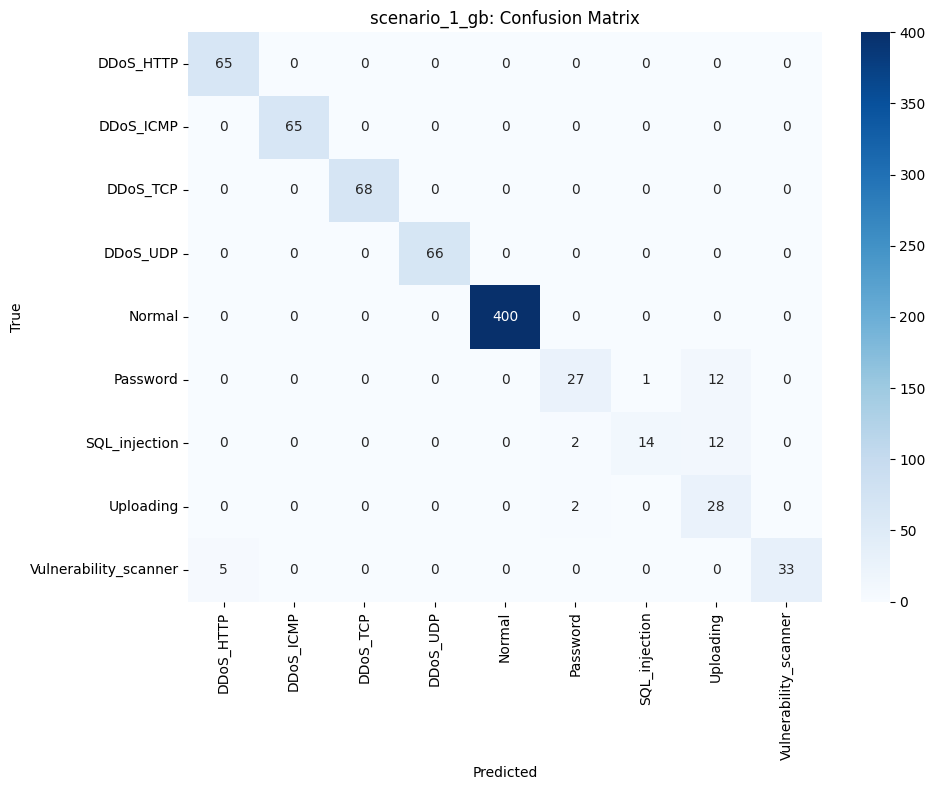


--- DNN (Default Settings) ---
Epoch 1/20 | Train Loss: 1.1197 | Val Loss: 0.5445 | Train Acc: 0.7617 | Val Acc: 0.8512
Epoch 2/20 | Train Loss: 0.3598 | Val Loss: 0.2287 | Train Acc: 0.9012 | Val Acc: 0.9113
Epoch 3/20 | Train Loss: 0.2142 | Val Loss: 0.1868 | Train Acc: 0.9179 | Val Acc: 0.9163
Epoch 4/20 | Train Loss: 0.1830 | Val Loss: 0.1808 | Train Acc: 0.9196 | Val Acc: 0.9175
Epoch 5/20 | Train Loss: 0.1768 | Val Loss: 0.1879 | Train Acc: 0.9208 | Val Acc: 0.9000
Epoch 6/20 | Train Loss: 0.1681 | Val Loss: 0.1732 | Train Acc: 0.9283 | Val Acc: 0.9200
Epoch 7/20 | Train Loss: 0.1691 | Val Loss: 0.1674 | Train Acc: 0.9246 | Val Acc: 0.9237
Epoch 8/20 | Train Loss: 0.1621 | Val Loss: 0.1721 | Train Acc: 0.9237 | Val Acc: 0.9100
Epoch 9/20 | Train Loss: 0.1565 | Val Loss: 0.1729 | Train Acc: 0.9300 | Val Acc: 0.9237
Epoch 10/20 | Train Loss: 0.1534 | Val Loss: 0.1739 | Train Acc: 0.9275 | Val Acc: 0.9163
Epoch 11/20 | Train Loss: 0.1587 | Val Loss: 0.1682 | Train Acc: 0.9246 | Val

<Figure size 640x480 with 0 Axes>

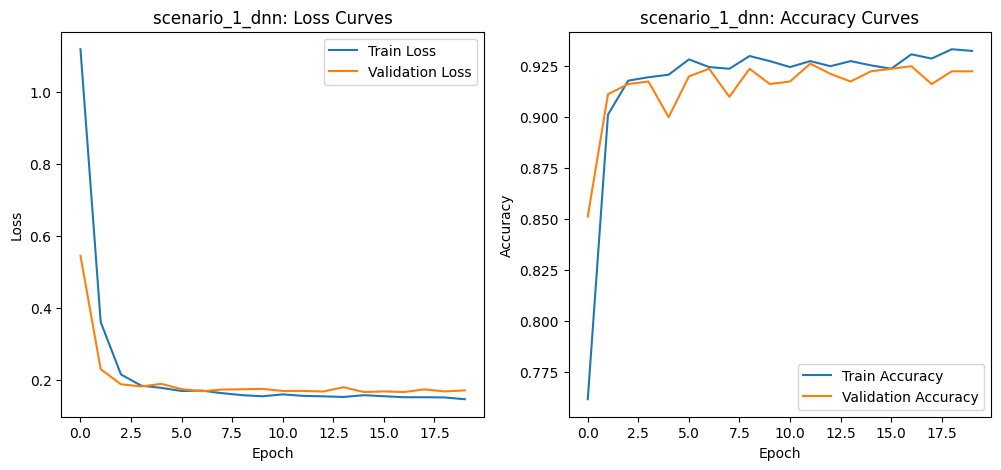

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.50      0.42      0.46        40
        SQL_injection       0.25      0.36      0.29        28
            Uploading       0.38      0.30      0.33        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.91       800
            macro avg       0.77      0.77      0.77       800
         weighted avg       0.92      0.91      0.91       800



<Figure size 640x480 with 0 Axes>

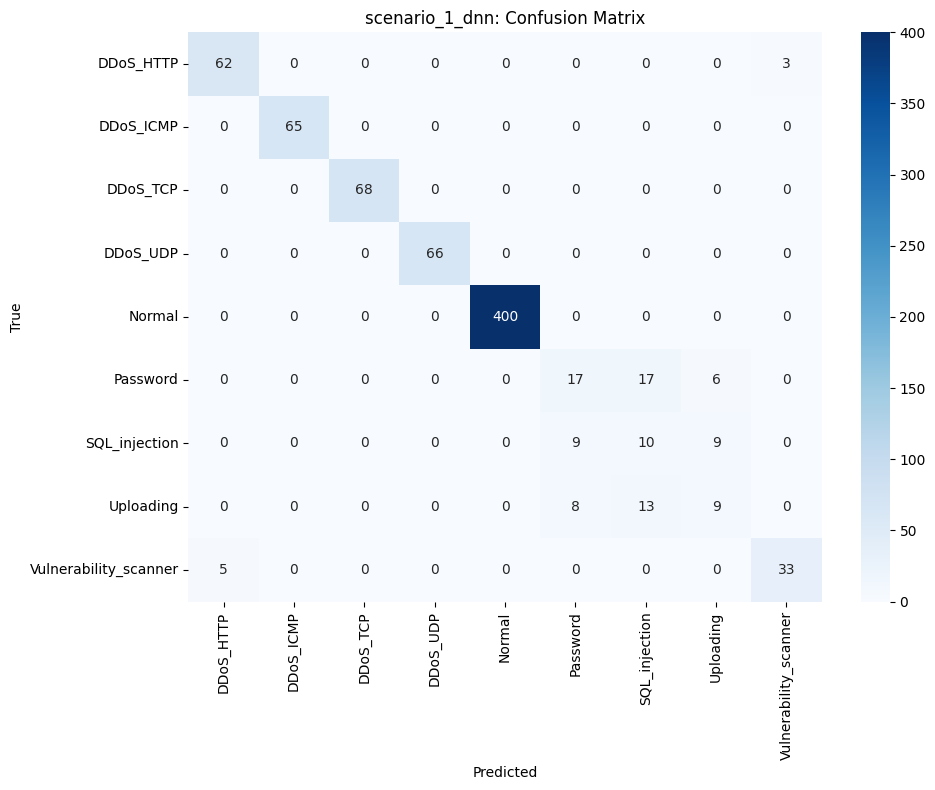

<Figure size 640x480 with 0 Axes>

In [10]:
scenario_1()


--- Scenario 2: Dataset Reduction and Parameter Variation ---

--- Gradient Boosting ---
Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      1.00      0.96        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.87      0.68      0.76        40
        SQL_injection       0.93      0.50      0.65        28
            Uploading       0.54      0.93      0.68        30
Vulnerability_scanner       1.00      0.87      0.93        38

             accuracy                           0.96       800
            macro avg       0.92      0.89      0.89       800
         weighted avg       0.97      0.96      0.96       800



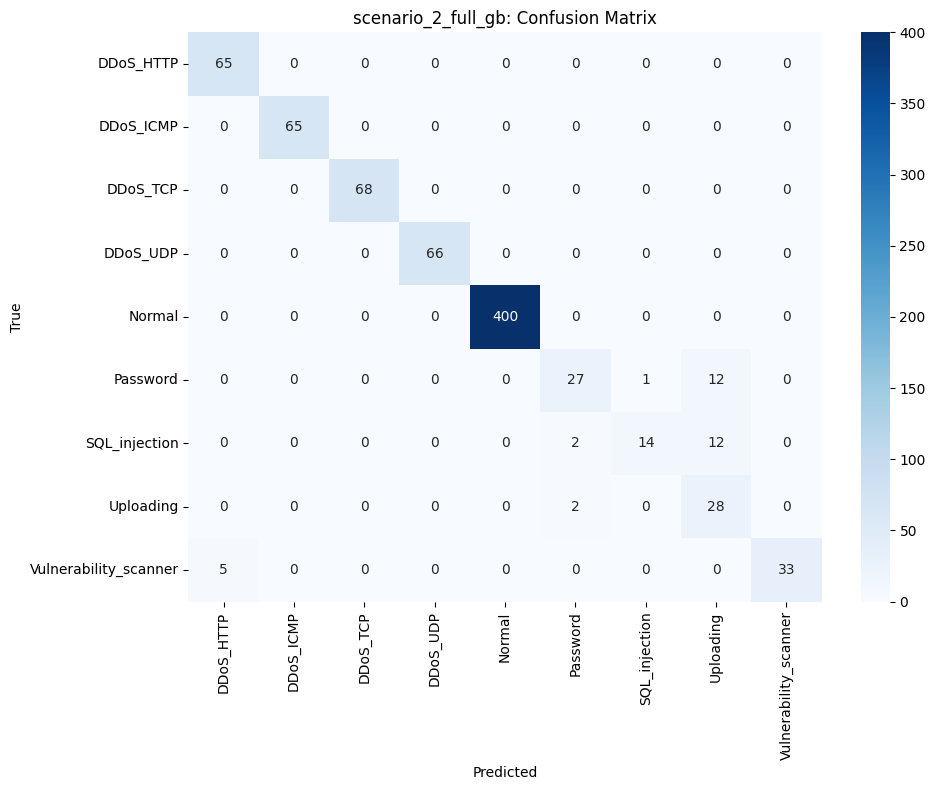


--- DNN (Default Settings) ---
Epoch 1/20 | Train Loss: 0.1483 | Val Loss: 0.1685 | Train Acc: 0.9350 | Val Acc: 0.9213
Epoch 2/20 | Train Loss: 0.1475 | Val Loss: 0.1644 | Train Acc: 0.9329 | Val Acc: 0.9237
Epoch 3/20 | Train Loss: 0.1449 | Val Loss: 0.1713 | Train Acc: 0.9287 | Val Acc: 0.9187
Epoch 4/20 | Train Loss: 0.1434 | Val Loss: 0.1697 | Train Acc: 0.9325 | Val Acc: 0.9213
Epoch 5/20 | Train Loss: 0.1456 | Val Loss: 0.1696 | Train Acc: 0.9304 | Val Acc: 0.9213
Epoch 6/20 | Train Loss: 0.1456 | Val Loss: 0.1740 | Train Acc: 0.9287 | Val Acc: 0.9225
Epoch 7/20 | Train Loss: 0.1448 | Val Loss: 0.1677 | Train Acc: 0.9283 | Val Acc: 0.9187
Epoch 8/20 | Train Loss: 0.1507 | Val Loss: 0.1707 | Train Acc: 0.9263 | Val Acc: 0.9187
Epoch 9/20 | Train Loss: 0.1461 | Val Loss: 0.1721 | Train Acc: 0.9275 | Val Acc: 0.9163
Epoch 10/20 | Train Loss: 0.1425 | Val Loss: 0.1689 | Train Acc: 0.9254 | Val Acc: 0.9213
Epoch 11/20 | Train Loss: 0.1406 | Val Loss: 0.1641 | Train Acc: 0.9313 | Val

<Figure size 640x480 with 0 Axes>

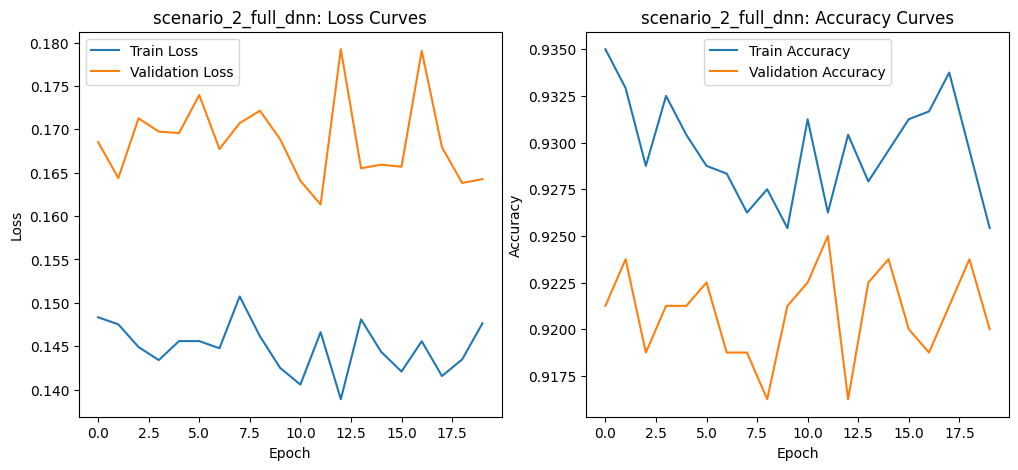

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.51      0.90      0.65        40
        SQL_injection       0.38      0.18      0.24        28
            Uploading       0.43      0.20      0.27        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.93       800
            macro avg       0.80      0.79      0.78       800
         weighted avg       0.92      0.93      0.92       800



<Figure size 640x480 with 0 Axes>

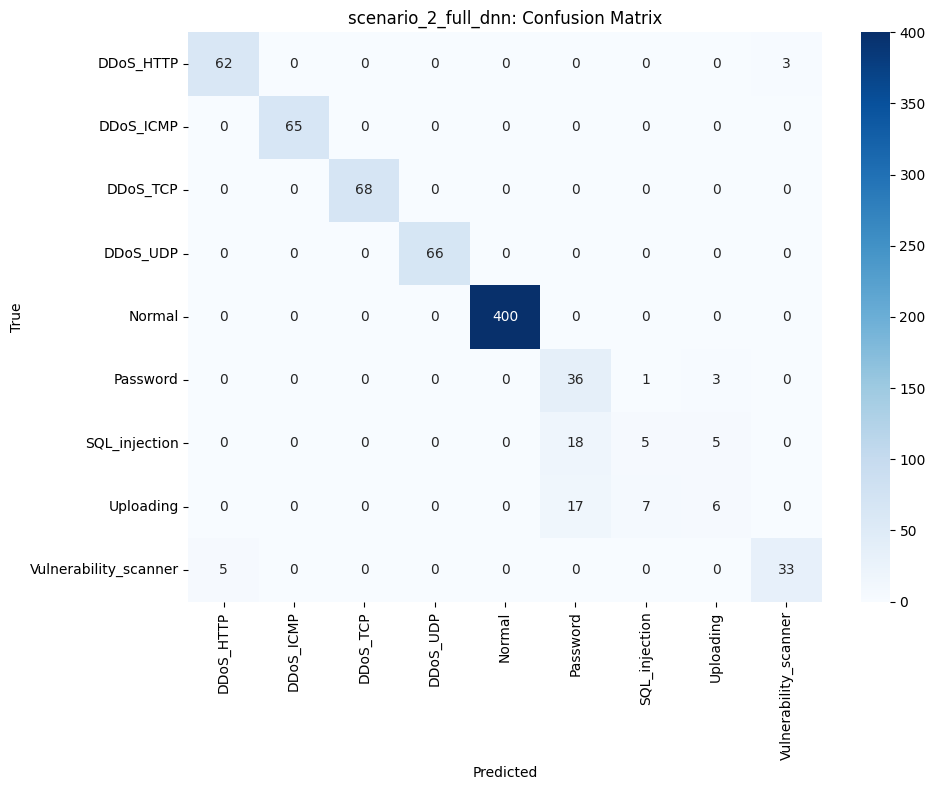


Training with learning rate: 0.01
Epoch 1/20 | Train Loss: 0.2118 | Val Loss: 0.2007 | Train Acc: 0.9050 | Val Acc: 0.9213
Epoch 2/20 | Train Loss: 0.1746 | Val Loss: 0.1648 | Train Acc: 0.9171 | Val Acc: 0.9125
Epoch 3/20 | Train Loss: 0.1688 | Val Loss: 0.1719 | Train Acc: 0.9221 | Val Acc: 0.9125
Epoch 4/20 | Train Loss: 0.1744 | Val Loss: 0.1939 | Train Acc: 0.9154 | Val Acc: 0.9187
Epoch 5/20 | Train Loss: 0.1742 | Val Loss: 0.1632 | Train Acc: 0.9246 | Val Acc: 0.9225
Epoch 6/20 | Train Loss: 0.1572 | Val Loss: 0.1692 | Train Acc: 0.9213 | Val Acc: 0.9087
Epoch 7/20 | Train Loss: 0.1619 | Val Loss: 0.1691 | Train Acc: 0.9258 | Val Acc: 0.9225
Epoch 8/20 | Train Loss: 0.1588 | Val Loss: 0.1676 | Train Acc: 0.9196 | Val Acc: 0.9200
Epoch 9/20 | Train Loss: 0.1568 | Val Loss: 0.1697 | Train Acc: 0.9233 | Val Acc: 0.9225
Epoch 10/20 | Train Loss: 0.1624 | Val Loss: 0.1755 | Train Acc: 0.9146 | Val Acc: 0.9250
Epoch 11/20 | Train Loss: 0.1570 | Val Loss: 0.1632 | Train Acc: 0.9204 | 

<Figure size 640x480 with 0 Axes>

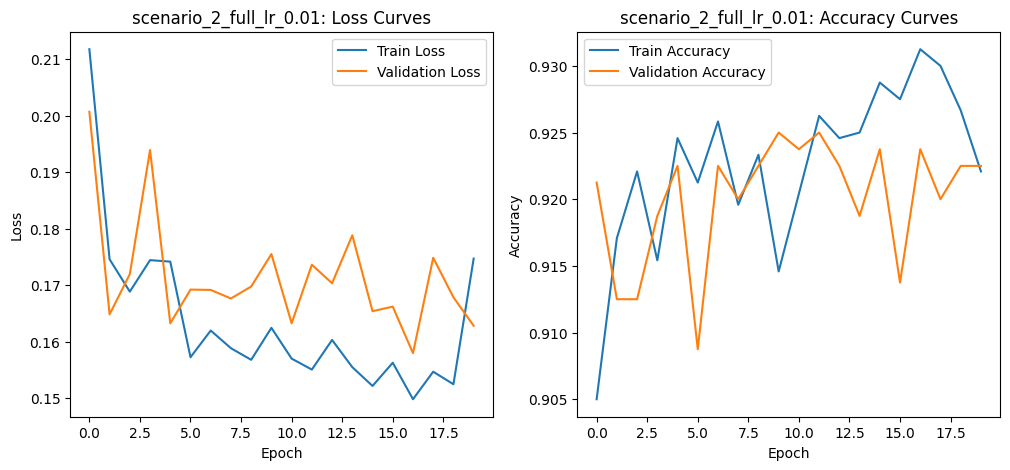

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       0.97      1.00      0.98        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      0.97      0.98        66
               Normal       1.00      1.00      1.00       400
             Password       0.49      0.97      0.65        40
        SQL_injection       0.45      0.18      0.26        28
            Uploading       0.71      0.17      0.27        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.93       800
            macro avg       0.83      0.79      0.78       800
         weighted avg       0.93      0.93      0.92       800



<Figure size 640x480 with 0 Axes>

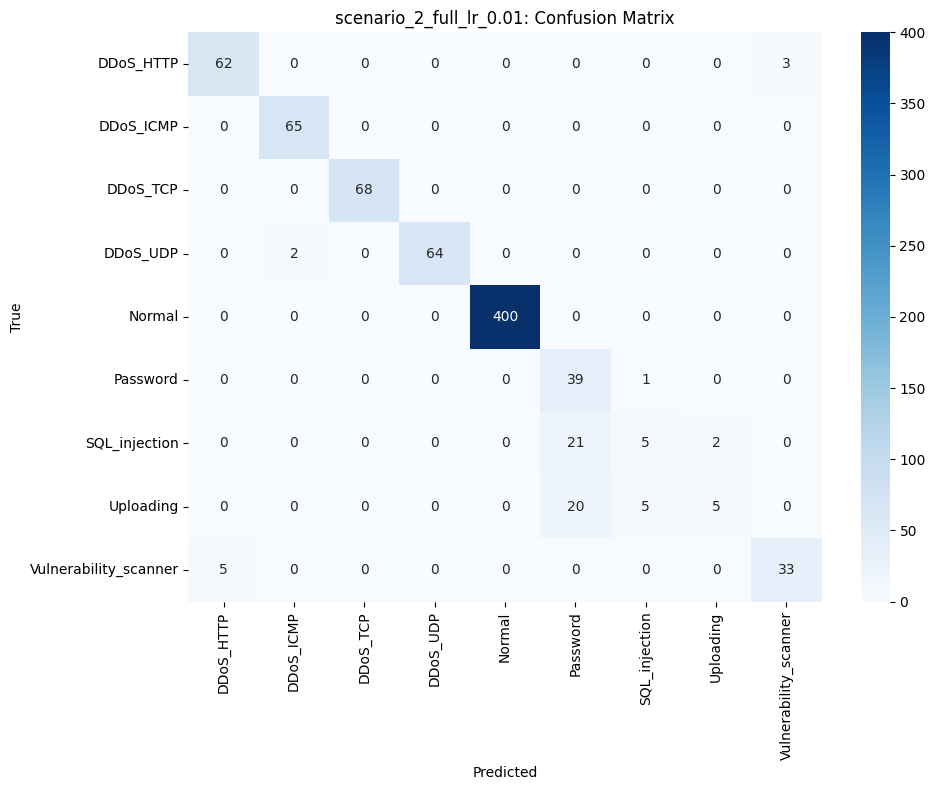


Training with learning rate: 0.05
Epoch 1/20 | Train Loss: 0.2944 | Val Loss: 0.2994 | Train Acc: 0.8858 | Val Acc: 0.8750
Epoch 2/20 | Train Loss: 0.2711 | Val Loss: 0.2024 | Train Acc: 0.8933 | Val Acc: 0.8950
Epoch 3/20 | Train Loss: 0.2516 | Val Loss: 0.1929 | Train Acc: 0.8904 | Val Acc: 0.8938
Epoch 4/20 | Train Loss: 0.2560 | Val Loss: 0.2036 | Train Acc: 0.8988 | Val Acc: 0.8962
Epoch 5/20 | Train Loss: 0.3309 | Val Loss: 0.2036 | Train Acc: 0.8825 | Val Acc: 0.9175
Epoch 6/20 | Train Loss: 0.2306 | Val Loss: 0.2025 | Train Acc: 0.8962 | Val Acc: 0.9062
Epoch 7/20 | Train Loss: 0.2751 | Val Loss: 0.3152 | Train Acc: 0.8958 | Val Acc: 0.8938
Epoch 8/20 | Train Loss: 0.2687 | Val Loss: 0.2346 | Train Acc: 0.8975 | Val Acc: 0.8938
Epoch 9/20 | Train Loss: 0.2464 | Val Loss: 0.2857 | Train Acc: 0.8967 | Val Acc: 0.8775
Epoch 10/20 | Train Loss: 0.3215 | Val Loss: 0.2491 | Train Acc: 0.8875 | Val Acc: 0.9025
Epoch 11/20 | Train Loss: 0.2675 | Val Loss: 0.1960 | Train Acc: 0.8946 | 

<Figure size 640x480 with 0 Axes>

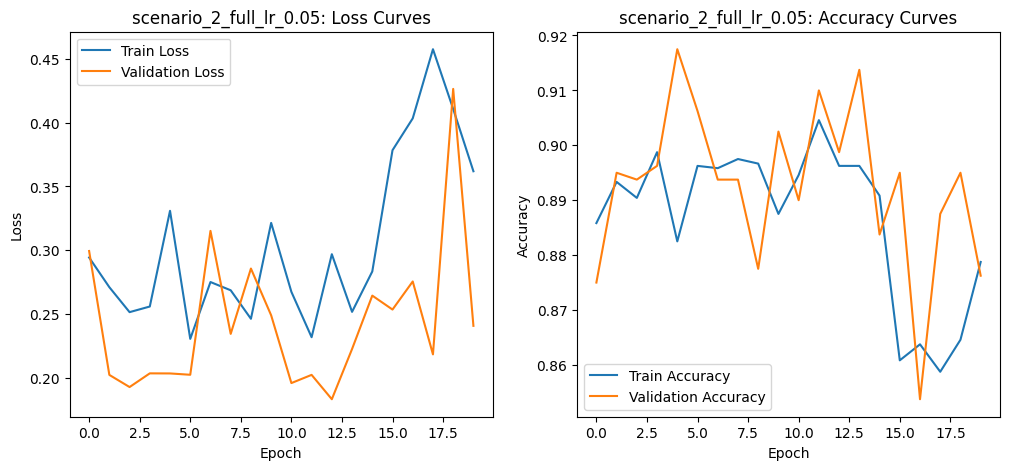

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       0.98      0.97      0.98        66
               Normal       1.00      1.00      1.00       400
             Password       0.00      0.00      0.00        40
        SQL_injection       0.26      0.86      0.40        28
            Uploading       0.00      0.00      0.00        30
Vulnerability_scanner       1.00      0.47      0.64        38

             accuracy                           0.88       800
            macro avg       0.69      0.69      0.66       800
         weighted avg       0.88      0.88      0.87       800



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

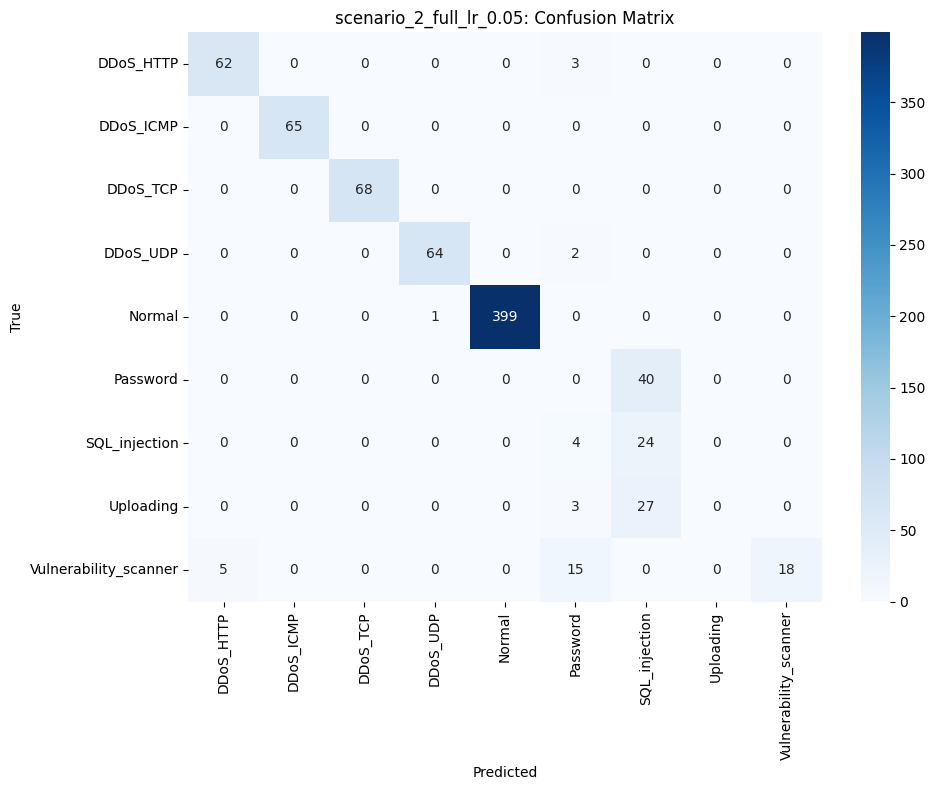


Training with learning rate: 0.001
Epoch 1/20 | Train Loss: 0.4849 | Val Loss: 0.1955 | Train Acc: 0.8662 | Val Acc: 0.9175
Epoch 2/20 | Train Loss: 0.3696 | Val Loss: 0.1751 | Train Acc: 0.8858 | Val Acc: 0.9175
Epoch 3/20 | Train Loss: 0.2485 | Val Loss: 0.1748 | Train Acc: 0.8921 | Val Acc: 0.9175
Epoch 4/20 | Train Loss: 0.2742 | Val Loss: 0.1718 | Train Acc: 0.8967 | Val Acc: 0.9187
Epoch 5/20 | Train Loss: 0.2437 | Val Loss: 0.1767 | Train Acc: 0.8992 | Val Acc: 0.9175
Epoch 6/20 | Train Loss: 0.2421 | Val Loss: 0.1702 | Train Acc: 0.9033 | Val Acc: 0.9187
Epoch 7/20 | Train Loss: 0.2358 | Val Loss: 0.1731 | Train Acc: 0.9079 | Val Acc: 0.9187
Epoch 8/20 | Train Loss: 0.2155 | Val Loss: 0.1696 | Train Acc: 0.9125 | Val Acc: 0.9187
Epoch 9/20 | Train Loss: 0.2174 | Val Loss: 0.1689 | Train Acc: 0.9117 | Val Acc: 0.9187
Epoch 10/20 | Train Loss: 0.2615 | Val Loss: 0.1694 | Train Acc: 0.9075 | Val Acc: 0.9187
Epoch 11/20 | Train Loss: 0.2039 | Val Loss: 0.1707 | Train Acc: 0.9108 |

<Figure size 640x480 with 0 Axes>

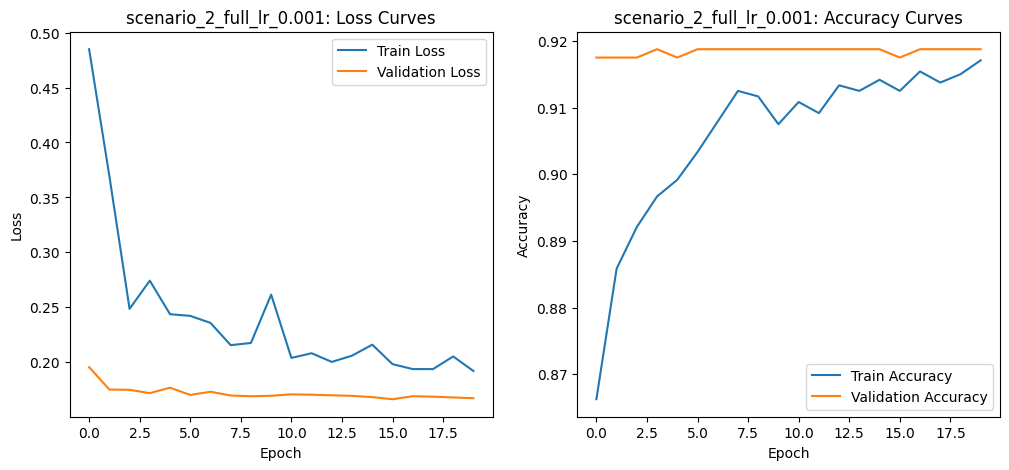

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.41      1.00      0.58        40
        SQL_injection       0.00      0.00      0.00        28
            Uploading       0.00      0.00      0.00        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.92       800
            macro avg       0.69      0.76      0.71       800
         weighted avg       0.89      0.92      0.90       800



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

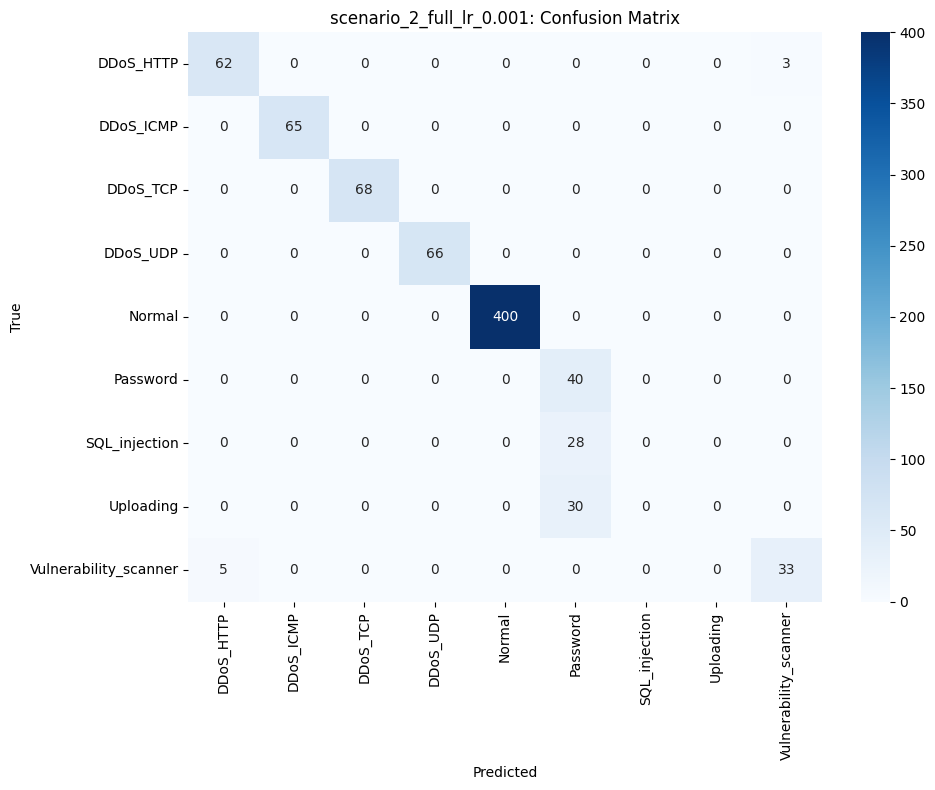


Training with batch size: 32
Epoch 1/20 | Train Loss: 0.1827 | Val Loss: 0.1738 | Train Acc: 0.9154 | Val Acc: 0.9187
Epoch 2/20 | Train Loss: 0.1793 | Val Loss: 0.1705 | Train Acc: 0.9187 | Val Acc: 0.9187
Epoch 3/20 | Train Loss: 0.1835 | Val Loss: 0.1687 | Train Acc: 0.9150 | Val Acc: 0.9187
Epoch 4/20 | Train Loss: 0.1787 | Val Loss: 0.1695 | Train Acc: 0.9179 | Val Acc: 0.9187
Epoch 5/20 | Train Loss: 0.1883 | Val Loss: 0.1700 | Train Acc: 0.9179 | Val Acc: 0.9187
Epoch 6/20 | Train Loss: 0.1917 | Val Loss: 0.1691 | Train Acc: 0.9175 | Val Acc: 0.9187
Epoch 7/20 | Train Loss: 0.1768 | Val Loss: 0.1707 | Train Acc: 0.9187 | Val Acc: 0.9187
Epoch 8/20 | Train Loss: 0.2059 | Val Loss: 0.1687 | Train Acc: 0.9200 | Val Acc: 0.9187
Epoch 9/20 | Train Loss: 0.1853 | Val Loss: 0.1675 | Train Acc: 0.9163 | Val Acc: 0.9187
Epoch 10/20 | Train Loss: 0.2232 | Val Loss: 0.1714 | Train Acc: 0.9175 | Val Acc: 0.9187
Epoch 11/20 | Train Loss: 0.1730 | Val Loss: 0.1701 | Train Acc: 0.9171 | Val A

<Figure size 640x480 with 0 Axes>

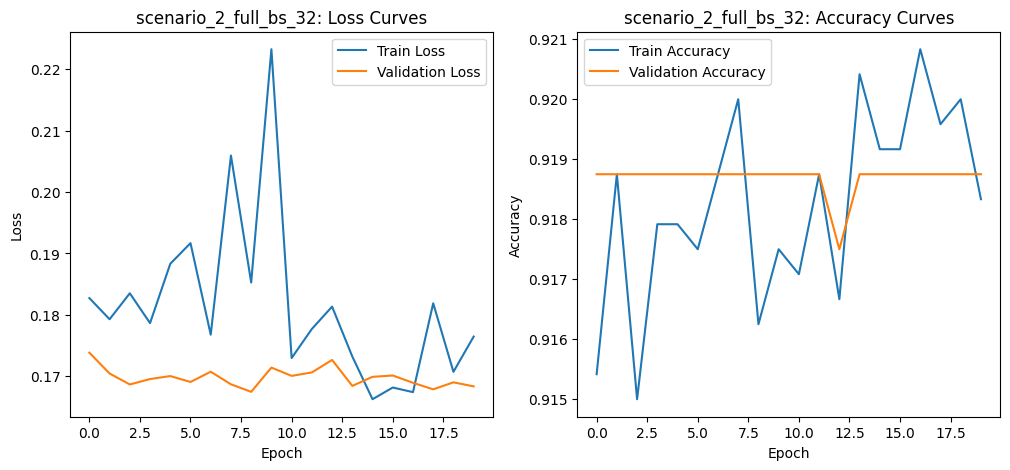

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.41      1.00      0.58        40
        SQL_injection       0.00      0.00      0.00        28
            Uploading       0.00      0.00      0.00        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.92       800
            macro avg       0.69      0.76      0.71       800
         weighted avg       0.89      0.92      0.90       800



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

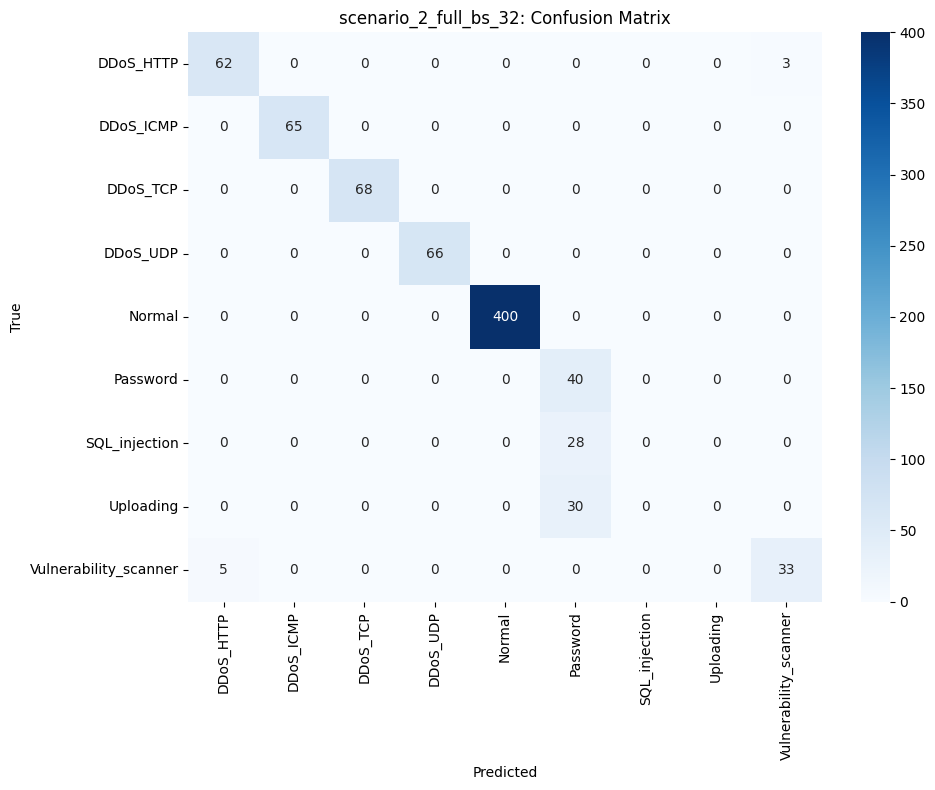


Training with batch size: 64
Epoch 1/20 | Train Loss: 0.1834 | Val Loss: 0.1690 | Train Acc: 0.9175 | Val Acc: 0.9187
Epoch 2/20 | Train Loss: 0.1650 | Val Loss: 0.1685 | Train Acc: 0.9204 | Val Acc: 0.9187
Epoch 3/20 | Train Loss: 0.1706 | Val Loss: 0.1692 | Train Acc: 0.9213 | Val Acc: 0.9187
Epoch 4/20 | Train Loss: 0.1632 | Val Loss: 0.1690 | Train Acc: 0.9196 | Val Acc: 0.9187
Epoch 5/20 | Train Loss: 0.1716 | Val Loss: 0.1691 | Train Acc: 0.9217 | Val Acc: 0.9187
Epoch 6/20 | Train Loss: 0.1699 | Val Loss: 0.1685 | Train Acc: 0.9208 | Val Acc: 0.9187
Epoch 7/20 | Train Loss: 0.1719 | Val Loss: 0.1680 | Train Acc: 0.9196 | Val Acc: 0.9187
Epoch 8/20 | Train Loss: 0.1653 | Val Loss: 0.1669 | Train Acc: 0.9208 | Val Acc: 0.9187
Epoch 9/20 | Train Loss: 0.1638 | Val Loss: 0.1688 | Train Acc: 0.9221 | Val Acc: 0.9187
Epoch 10/20 | Train Loss: 0.1609 | Val Loss: 0.1690 | Train Acc: 0.9200 | Val Acc: 0.9187
Epoch 11/20 | Train Loss: 0.1961 | Val Loss: 0.1678 | Train Acc: 0.9200 | Val A

<Figure size 640x480 with 0 Axes>

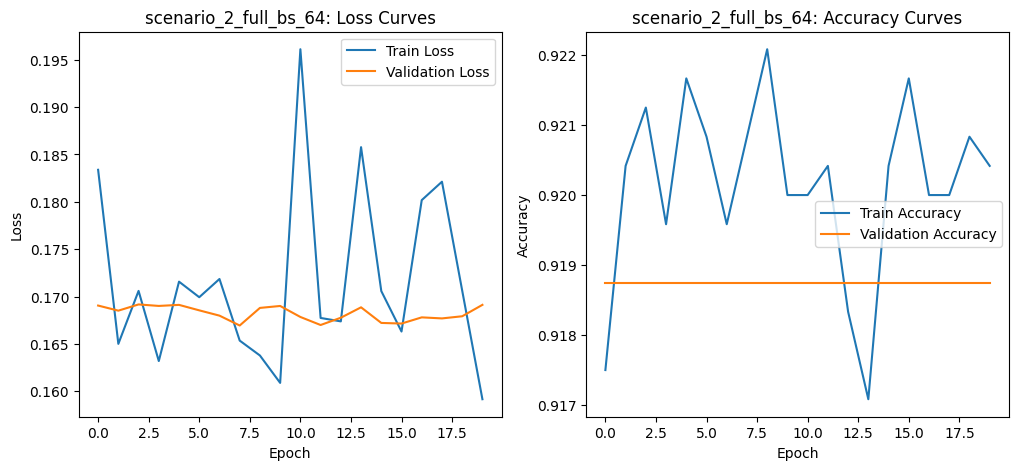

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.41      1.00      0.58        40
        SQL_injection       0.00      0.00      0.00        28
            Uploading       0.00      0.00      0.00        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.92       800
            macro avg       0.69      0.76      0.71       800
         weighted avg       0.89      0.92      0.90       800



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

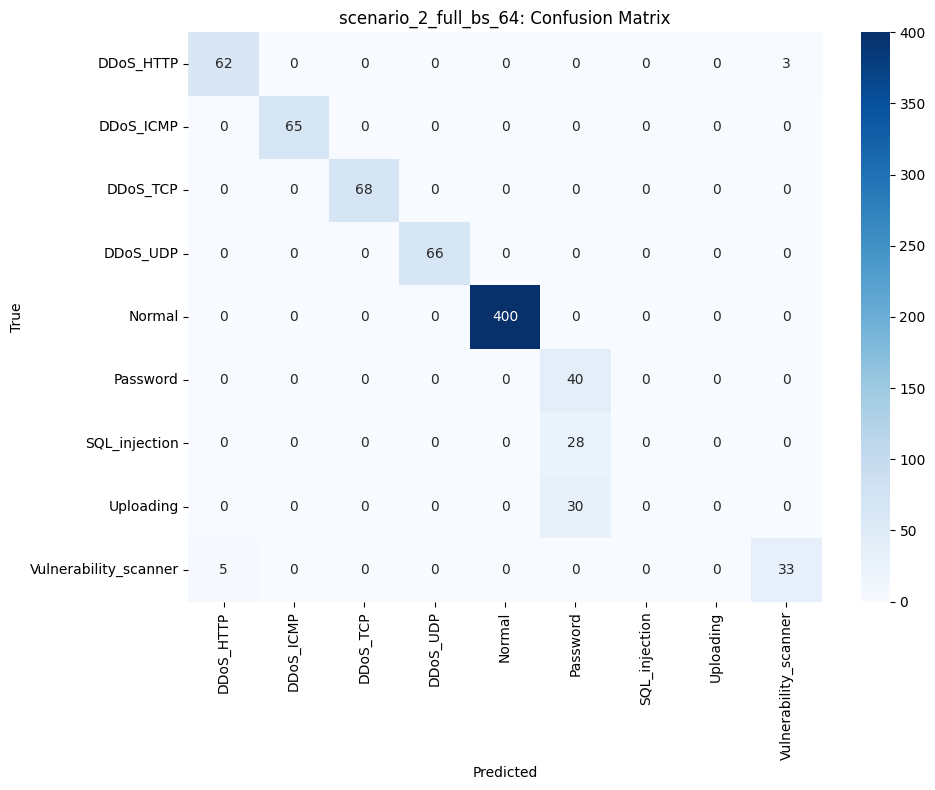


--- Gradient Boosting ---
Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       0.50      0.40      0.44         5
        SQL_injection       0.67      0.67      0.67         3
            Uploading       0.33      0.50      0.40         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.94        80
            macro avg       0.83      0.84      0.83        80
         weighted avg       0.94      0.94      0.94        80



<Figure size 640x480 with 0 Axes>

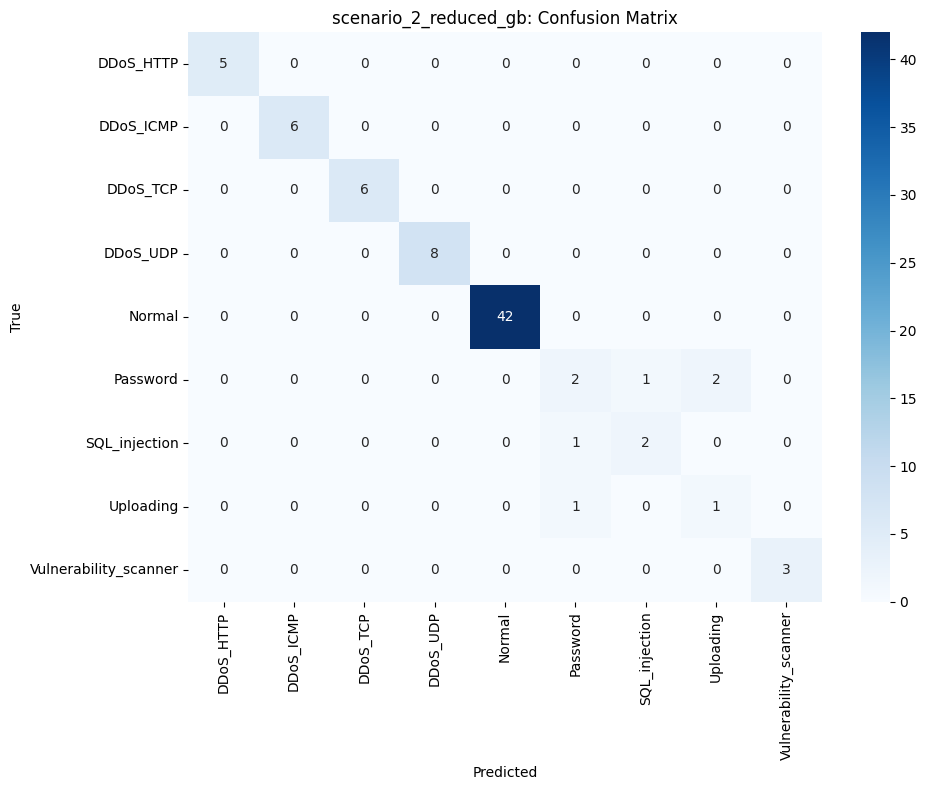


--- DNN (Default Settings) ---
Epoch 1/20 | Train Loss: 0.1671 | Val Loss: 0.1324 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 2/20 | Train Loss: 0.1614 | Val Loss: 0.1325 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 3/20 | Train Loss: 0.1603 | Val Loss: 0.1324 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 4/20 | Train Loss: 0.1697 | Val Loss: 0.1320 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 5/20 | Train Loss: 0.1535 | Val Loss: 0.1321 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 6/20 | Train Loss: 0.1559 | Val Loss: 0.1324 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 7/20 | Train Loss: 0.1705 | Val Loss: 0.1323 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 8/20 | Train Loss: 0.1585 | Val Loss: 0.1324 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 9/20 | Train Loss: 0.1472 | Val Loss: 0.1325 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 10/20 | Train Loss: 0.1539 | Val Loss: 0.1317 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 11/20 | Train Loss: 0.1624 | Val Loss: 0.1315 | Train Acc: 0.9208 | Val

<Figure size 640x480 with 0 Axes>

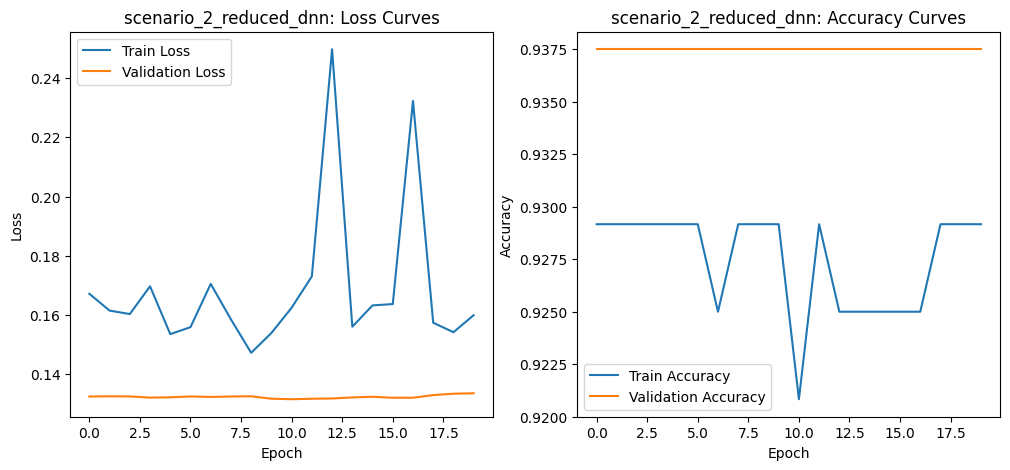

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       0.50      1.00      0.67         5
        SQL_injection       0.00      0.00      0.00         3
            Uploading       0.00      0.00      0.00         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.94        80
            macro avg       0.72      0.78      0.74        80
         weighted avg       0.91      0.94      0.92        80



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

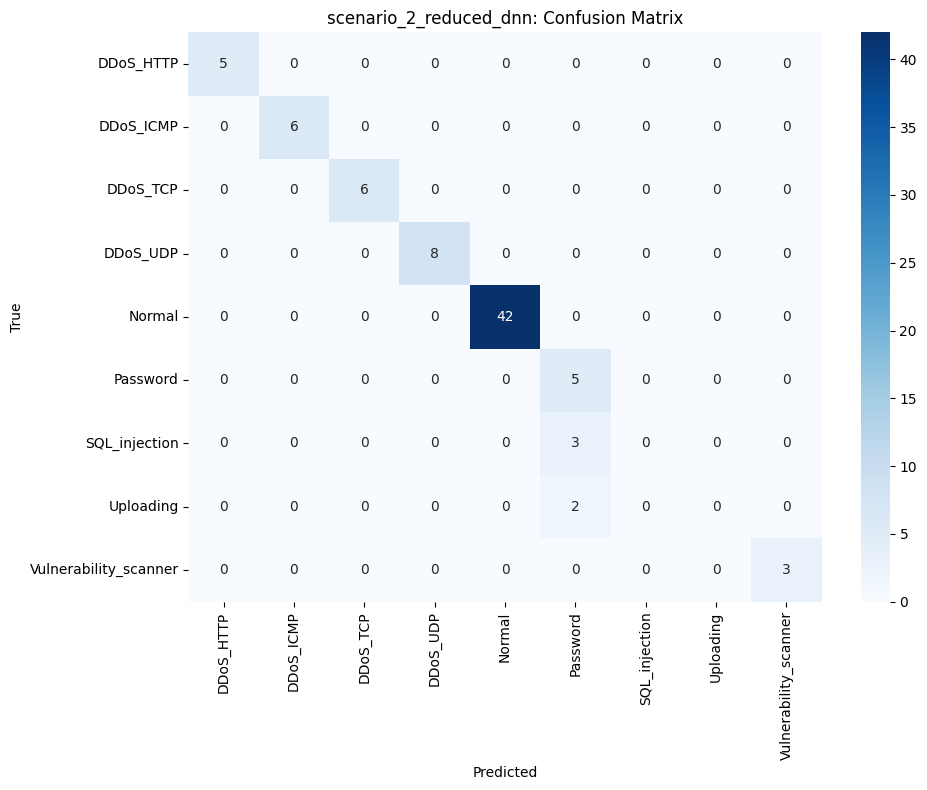


Training with learning rate: 0.01
Epoch 1/20 | Train Loss: 0.2035 | Val Loss: 0.1320 | Train Acc: 0.9208 | Val Acc: 0.9375
Epoch 2/20 | Train Loss: 0.1691 | Val Loss: 0.1349 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 3/20 | Train Loss: 0.1538 | Val Loss: 0.1321 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 4/20 | Train Loss: 0.1783 | Val Loss: 0.1312 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 5/20 | Train Loss: 0.1665 | Val Loss: 0.1406 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 6/20 | Train Loss: 0.1754 | Val Loss: 0.1370 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 7/20 | Train Loss: 0.1624 | Val Loss: 0.1334 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 8/20 | Train Loss: 0.1629 | Val Loss: 0.1335 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 9/20 | Train Loss: 0.1564 | Val Loss: 0.1314 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 10/20 | Train Loss: 0.1682 | Val Loss: 0.1336 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 11/20 | Train Loss: 0.1668 | Val Loss: 0.1334 | Train Acc: 0.9292 | 

<Figure size 640x480 with 0 Axes>

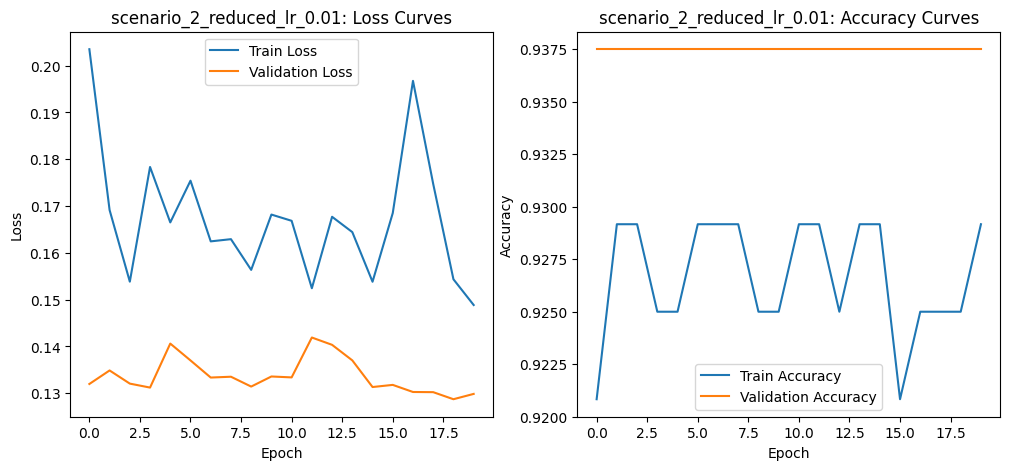

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       0.50      1.00      0.67         5
        SQL_injection       0.00      0.00      0.00         3
            Uploading       0.00      0.00      0.00         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.94        80
            macro avg       0.72      0.78      0.74        80
         weighted avg       0.91      0.94      0.92        80



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

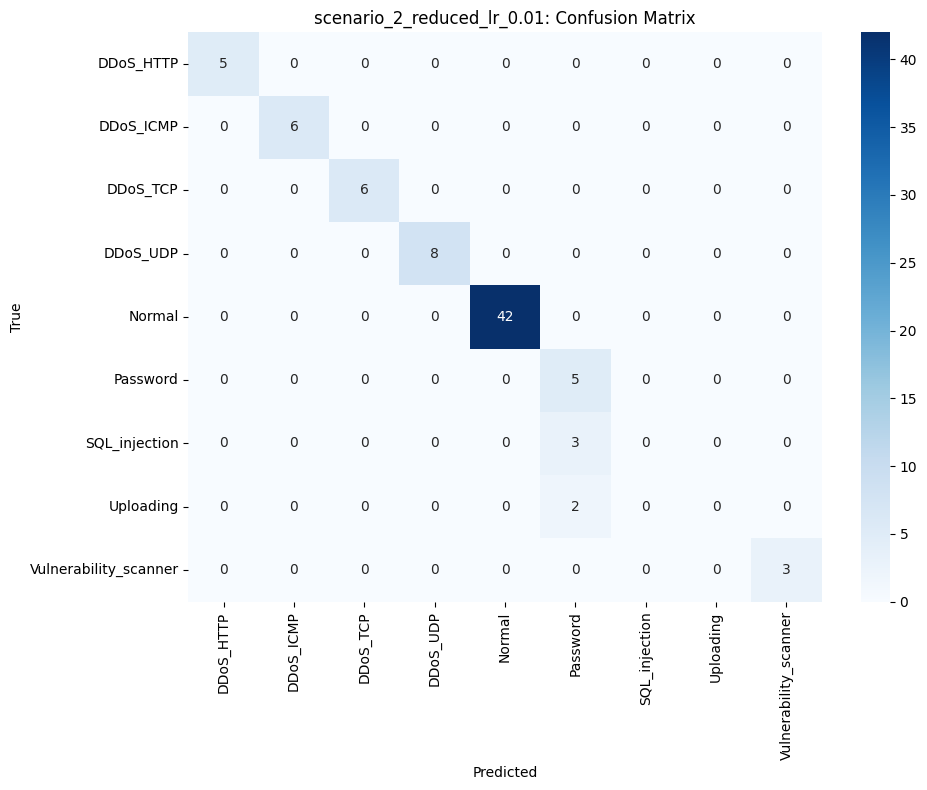


Training with learning rate: 0.05
Epoch 1/20 | Train Loss: 0.2514 | Val Loss: 0.3726 | Train Acc: 0.8875 | Val Acc: 0.9000
Epoch 2/20 | Train Loss: 0.3716 | Val Loss: 0.2062 | Train Acc: 0.8917 | Val Acc: 0.9125
Epoch 3/20 | Train Loss: 0.3391 | Val Loss: 0.1736 | Train Acc: 0.9000 | Val Acc: 0.9375
Epoch 4/20 | Train Loss: 0.2094 | Val Loss: 0.1473 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 5/20 | Train Loss: 0.2289 | Val Loss: 0.1429 | Train Acc: 0.9125 | Val Acc: 0.9000
Epoch 6/20 | Train Loss: 0.2039 | Val Loss: 0.2882 | Train Acc: 0.9125 | Val Acc: 0.9250
Epoch 7/20 | Train Loss: 0.5926 | Val Loss: 0.1492 | Train Acc: 0.9125 | Val Acc: 0.9375
Epoch 8/20 | Train Loss: 0.1949 | Val Loss: 0.1680 | Train Acc: 0.9167 | Val Acc: 0.9375
Epoch 9/20 | Train Loss: 0.2143 | Val Loss: 0.1931 | Train Acc: 0.9083 | Val Acc: 0.9250
Epoch 10/20 | Train Loss: 0.3014 | Val Loss: 0.2275 | Train Acc: 0.9208 | Val Acc: 0.9250
Epoch 11/20 | Train Loss: 0.2116 | Val Loss: 0.1934 | Train Acc: 0.9250 | 

<Figure size 640x480 with 0 Axes>

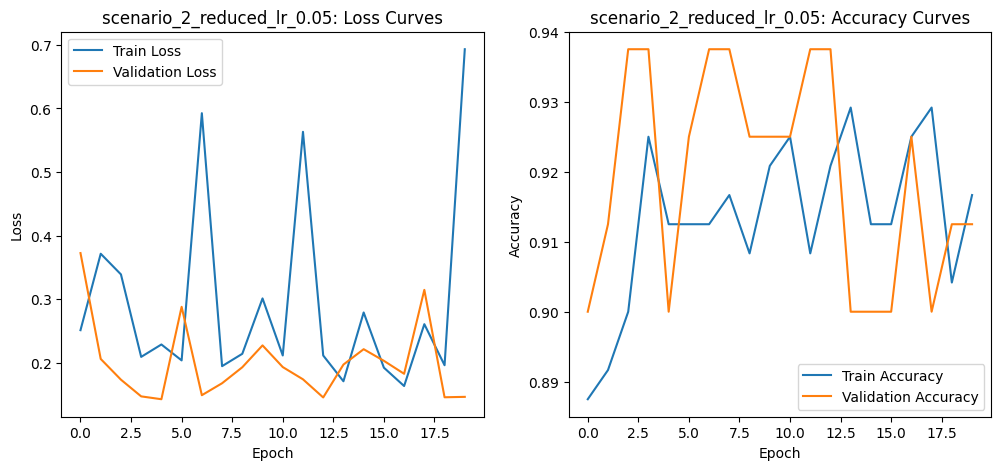

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       1.00      0.40      0.57         5
        SQL_injection       0.38      1.00      0.55         3
            Uploading       0.00      0.00      0.00         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.94        80
            macro avg       0.82      0.82      0.79        80
         weighted avg       0.95      0.94      0.93        80



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

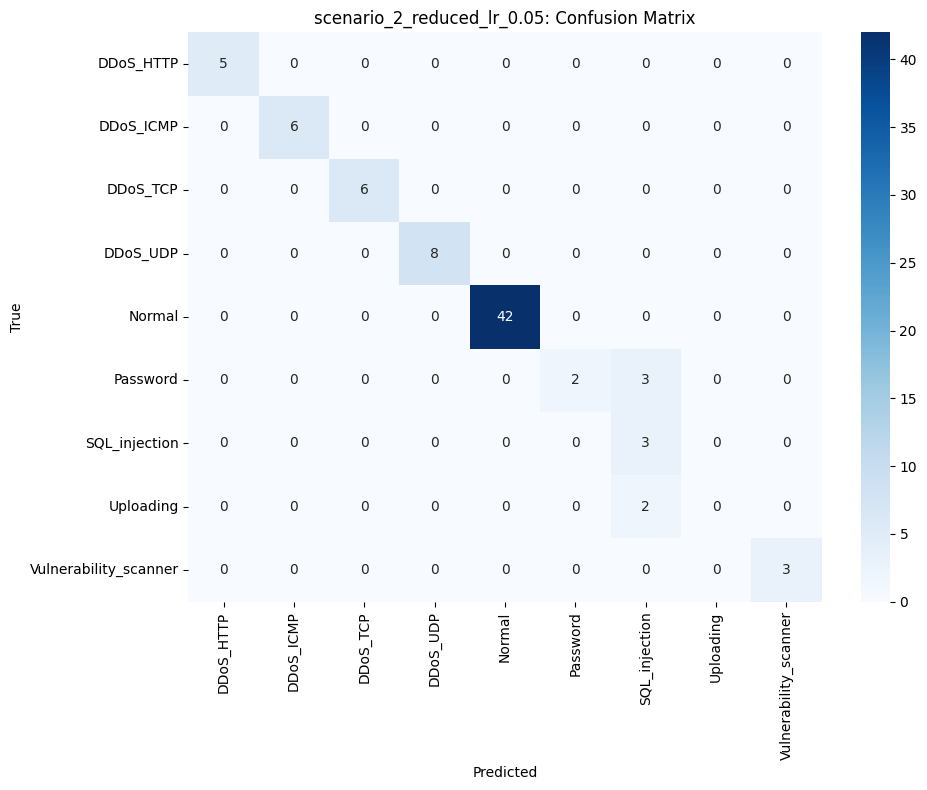


Training with learning rate: 0.001
Epoch 1/20 | Train Loss: 0.8863 | Val Loss: 0.1465 | Train Acc: 0.8958 | Val Acc: 0.9125
Epoch 2/20 | Train Loss: 5.0673 | Val Loss: 0.1461 | Train Acc: 0.9000 | Val Acc: 0.9125
Epoch 3/20 | Train Loss: 0.2562 | Val Loss: 0.1463 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 4/20 | Train Loss: 2.6399 | Val Loss: 0.1459 | Train Acc: 0.9042 | Val Acc: 0.9375
Epoch 5/20 | Train Loss: 0.2284 | Val Loss: 0.1455 | Train Acc: 0.9208 | Val Acc: 0.9375
Epoch 6/20 | Train Loss: 0.1713 | Val Loss: 0.1449 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 7/20 | Train Loss: 0.2330 | Val Loss: 0.1458 | Train Acc: 0.9167 | Val Acc: 0.9375
Epoch 8/20 | Train Loss: 0.4065 | Val Loss: 0.1451 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 9/20 | Train Loss: 0.1684 | Val Loss: 0.1449 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 10/20 | Train Loss: 1.2748 | Val Loss: 0.1454 | Train Acc: 0.9167 | Val Acc: 0.9375
Epoch 11/20 | Train Loss: 0.1863 | Val Loss: 0.1454 | Train Acc: 0.9292 |

<Figure size 640x480 with 0 Axes>

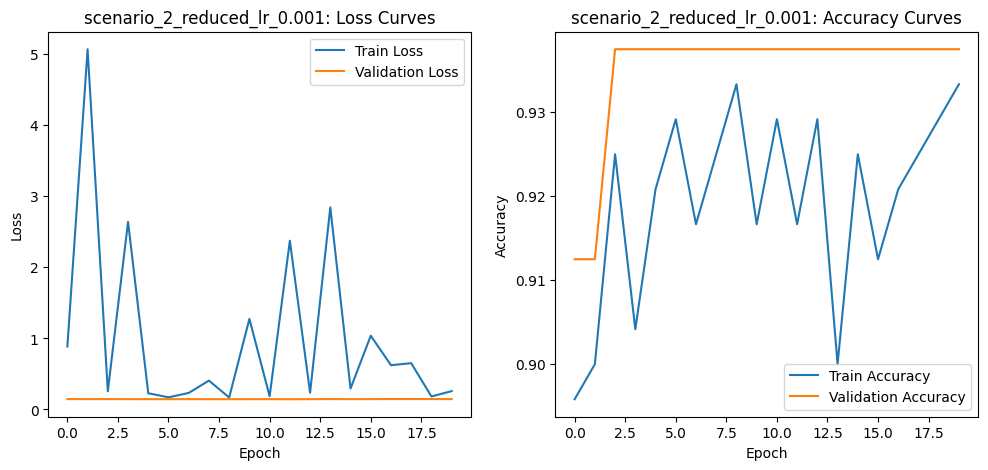

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       0.56      1.00      0.71         5
        SQL_injection       1.00      0.33      0.50         3
            Uploading       0.00      0.00      0.00         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.95        80
            macro avg       0.84      0.81      0.80        80
         weighted avg       0.95      0.95      0.94        80



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

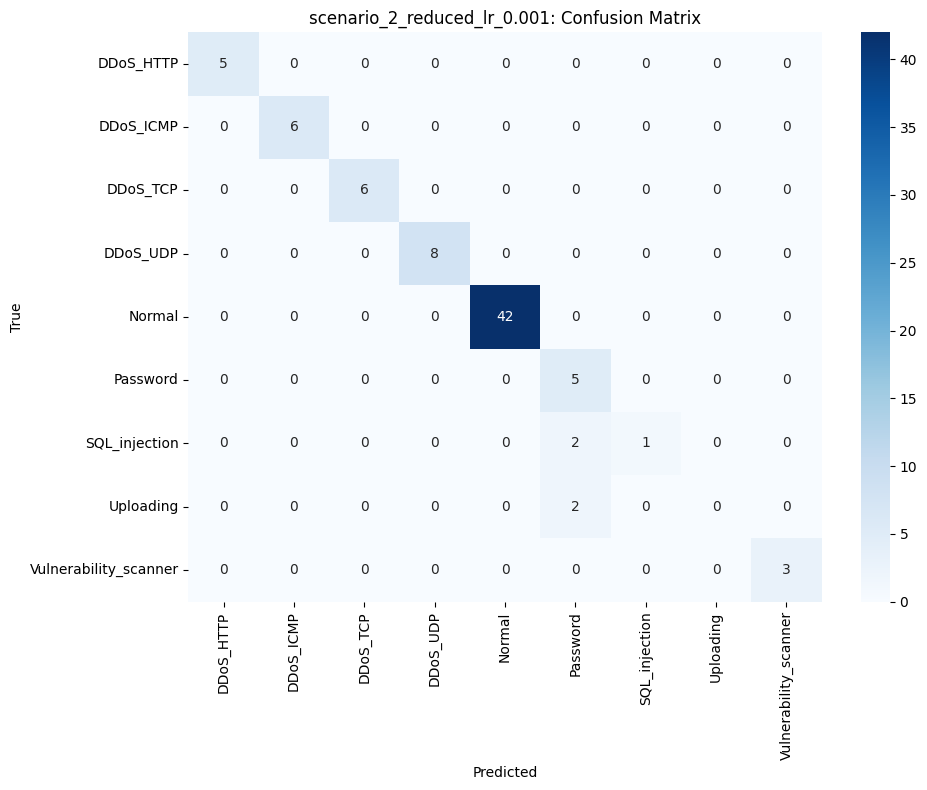


Training with batch size: 32
Epoch 1/20 | Train Loss: 0.1705 | Val Loss: 0.1461 | Train Acc: 0.9375 | Val Acc: 0.9375
Epoch 2/20 | Train Loss: 0.3601 | Val Loss: 0.1469 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 3/20 | Train Loss: 0.5041 | Val Loss: 0.1476 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 4/20 | Train Loss: 0.1486 | Val Loss: 0.1474 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 5/20 | Train Loss: 0.2518 | Val Loss: 0.1474 | Train Acc: 0.9375 | Val Acc: 0.9375
Epoch 6/20 | Train Loss: 0.1509 | Val Loss: 0.1475 | Train Acc: 0.9417 | Val Acc: 0.9375
Epoch 7/20 | Train Loss: 0.3817 | Val Loss: 0.1476 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 8/20 | Train Loss: 0.1669 | Val Loss: 0.1483 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 9/20 | Train Loss: 0.1832 | Val Loss: 0.1470 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 10/20 | Train Loss: 0.4370 | Val Loss: 0.1467 | Train Acc: 0.9250 | Val Acc: 0.9375
Epoch 11/20 | Train Loss: 0.1504 | Val Loss: 0.1469 | Train Acc: 0.9292 | Val A

<Figure size 640x480 with 0 Axes>

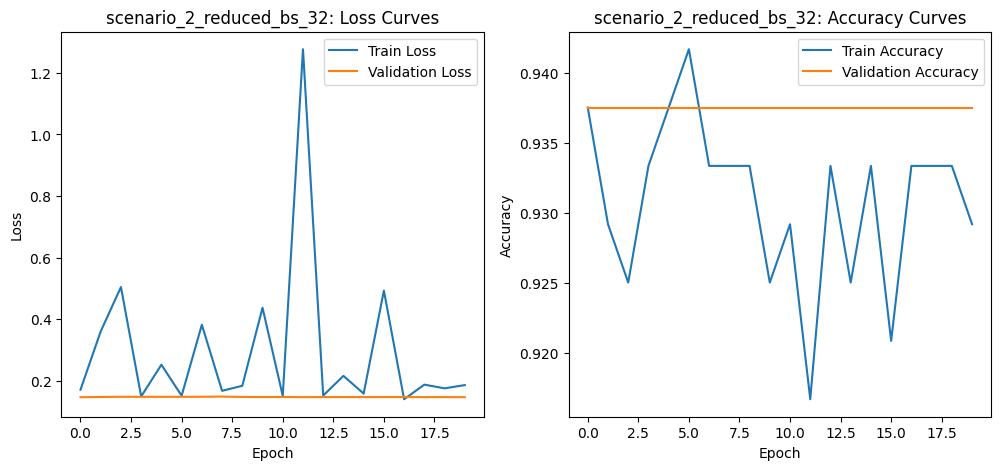

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       0.56      1.00      0.71         5
        SQL_injection       1.00      0.33      0.50         3
            Uploading       0.00      0.00      0.00         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.95        80
            macro avg       0.84      0.81      0.80        80
         weighted avg       0.95      0.95      0.94        80



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

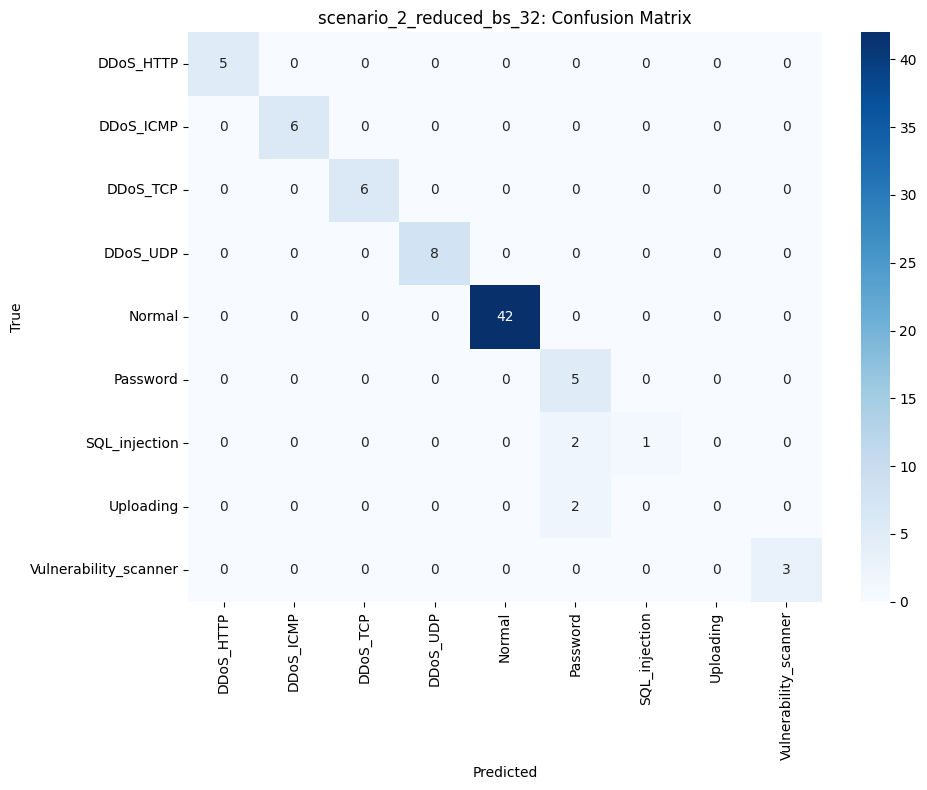


Training with batch size: 64
Epoch 1/20 | Train Loss: 0.1526 | Val Loss: 0.1470 | Train Acc: 0.9375 | Val Acc: 0.9375
Epoch 2/20 | Train Loss: 0.1467 | Val Loss: 0.1472 | Train Acc: 0.9375 | Val Acc: 0.9375
Epoch 3/20 | Train Loss: 0.1738 | Val Loss: 0.1473 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 4/20 | Train Loss: 0.1394 | Val Loss: 0.1475 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 5/20 | Train Loss: 0.3995 | Val Loss: 0.1477 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 6/20 | Train Loss: 0.1346 | Val Loss: 0.1479 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 7/20 | Train Loss: 0.3706 | Val Loss: 0.1482 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 8/20 | Train Loss: 0.1595 | Val Loss: 0.1472 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 9/20 | Train Loss: 0.1726 | Val Loss: 0.1472 | Train Acc: 0.9292 | Val Acc: 0.9375
Epoch 10/20 | Train Loss: 0.1600 | Val Loss: 0.1467 | Train Acc: 0.9333 | Val Acc: 0.9375
Epoch 11/20 | Train Loss: 0.1531 | Val Loss: 0.1448 | Train Acc: 0.9333 | Val A

<Figure size 640x480 with 0 Axes>

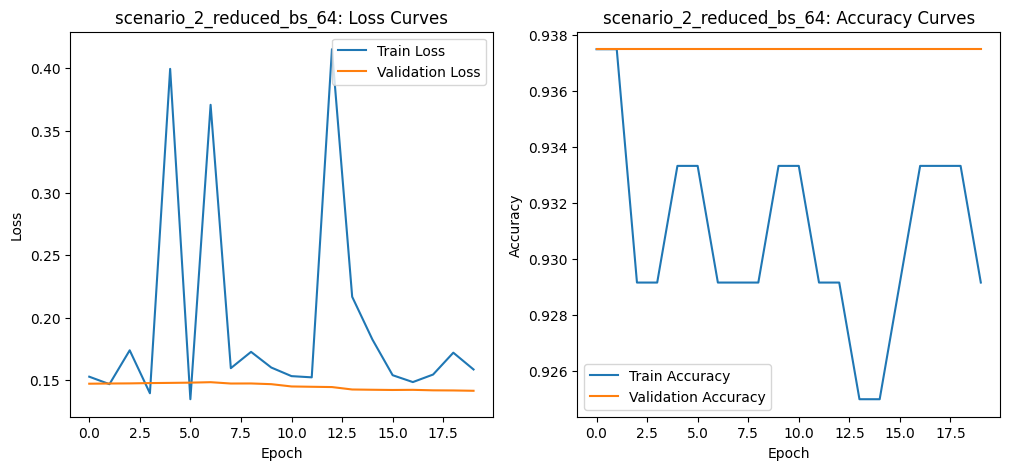

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       1.00      1.00      1.00         5
            DDoS_ICMP       1.00      1.00      1.00         6
             DDoS_TCP       1.00      1.00      1.00         6
             DDoS_UDP       1.00      1.00      1.00         8
               Normal       1.00      1.00      1.00        42
             Password       0.56      1.00      0.71         5
        SQL_injection       1.00      0.33      0.50         3
            Uploading       0.00      0.00      0.00         2
Vulnerability_scanner       1.00      1.00      1.00         3

             accuracy                           0.95        80
            macro avg       0.84      0.81      0.80        80
         weighted avg       0.95      0.95      0.94        80



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

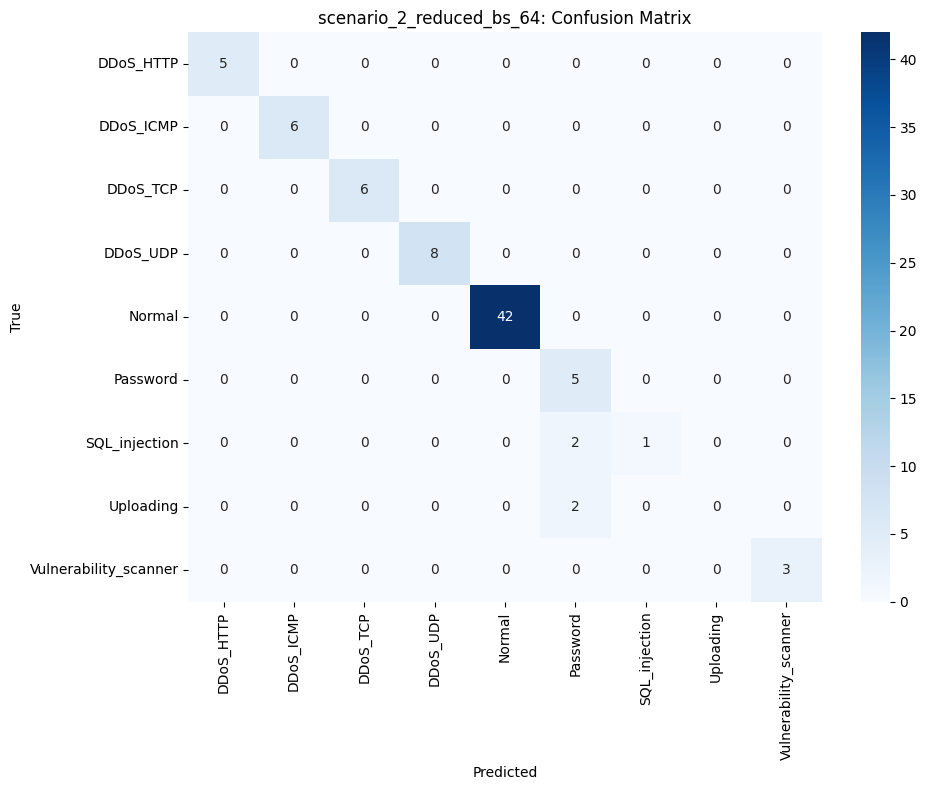

<Figure size 640x480 with 0 Axes>

In [11]:
scenario_2()


--- Scenario 3: Class Exclusion Experiment ---

--- Gradient Boosting ---
Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.92      1.00      0.96        65
             Password       0.76      1.00      0.86        41
        SQL_injection       0.89      0.61      0.72        28
            Uploading       0.92      0.80      0.86        30
Vulnerability_scanner       1.00      0.84      0.91        37

             accuracy                           0.89       201
            macro avg       0.90      0.85      0.86       201
         weighted avg       0.90      0.89      0.88       201



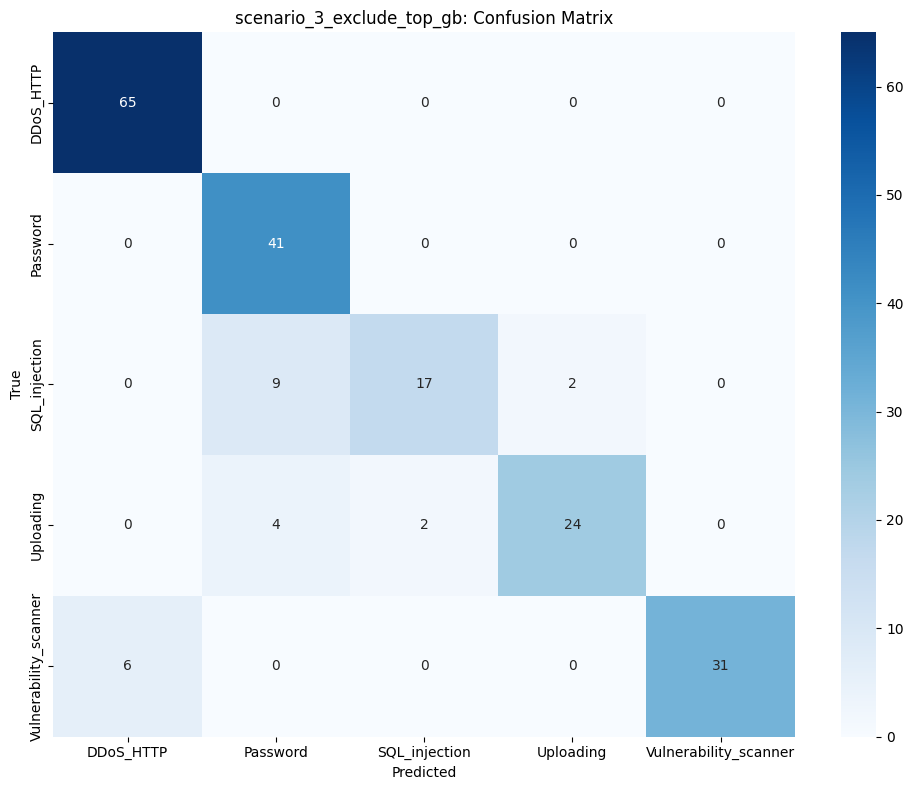


--- DNN (Default Settings) ---
Epoch 1/20 | Train Loss: 307.8830 | Val Loss: 241.0022 | Train Acc: 0.1265 | Val Acc: 0.0647
Epoch 2/20 | Train Loss: 278.5248 | Val Loss: 208.4413 | Train Acc: 0.1348 | Val Acc: 0.0647
Epoch 3/20 | Train Loss: 253.6229 | Val Loss: 174.1141 | Train Acc: 0.1398 | Val Acc: 0.0647
Epoch 4/20 | Train Loss: 207.0165 | Val Loss: 149.5462 | Train Acc: 0.1730 | Val Acc: 0.0697
Epoch 5/20 | Train Loss: 185.4451 | Val Loss: 117.7185 | Train Acc: 0.2080 | Val Acc: 0.1343
Epoch 6/20 | Train Loss: 152.7577 | Val Loss: 96.4015 | Train Acc: 0.2263 | Val Acc: 0.2537
Epoch 7/20 | Train Loss: 128.5223 | Val Loss: 73.9551 | Train Acc: 0.2712 | Val Acc: 0.3731
Epoch 8/20 | Train Loss: 107.8322 | Val Loss: 54.6360 | Train Acc: 0.2928 | Val Acc: 0.4776
Epoch 9/20 | Train Loss: 91.3641 | Val Loss: 42.9757 | Train Acc: 0.3661 | Val Acc: 0.5373
Epoch 10/20 | Train Loss: 71.0074 | Val Loss: 33.6724 | Train Acc: 0.3710 | Val Acc: 0.5771
Epoch 11/20 | Train Loss: 64.1204 | Val Loss

<Figure size 640x480 with 0 Axes>

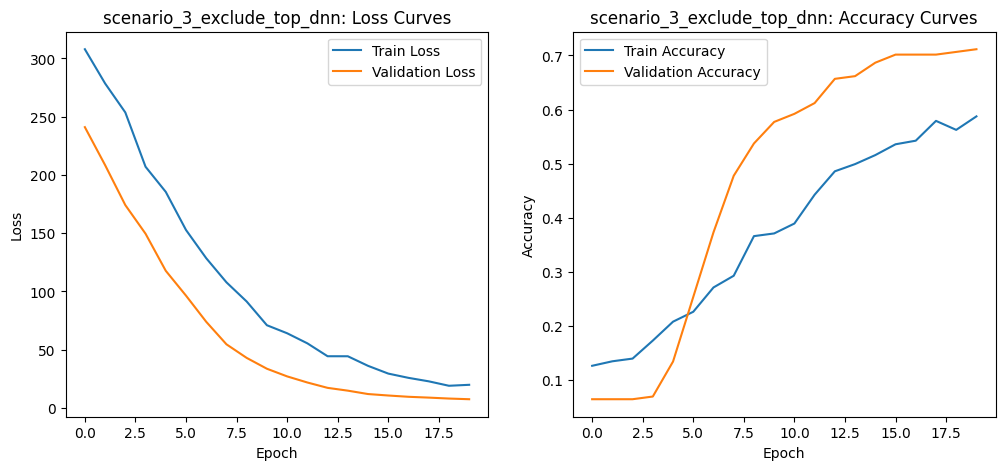

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.97      0.95        65
             Password       0.43      0.68      0.53        41
        SQL_injection       0.33      0.21      0.26        28
            Uploading       0.53      0.27      0.36        30
Vulnerability_scanner       0.94      0.86      0.90        37

            micro avg       0.69      0.68      0.68       201
            macro avg       0.63      0.60      0.60       201
         weighted avg       0.69      0.68      0.67       201



<Figure size 640x480 with 0 Axes>

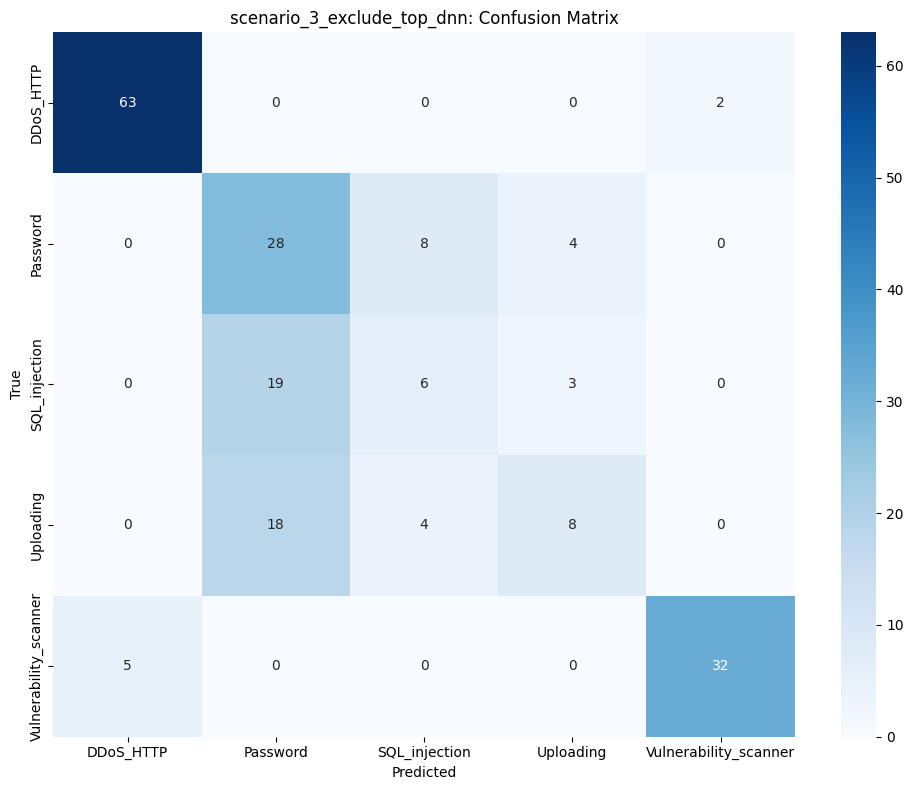


--- Gradient Boosting ---
Classification Report:
              precision    recall  f1-score   support

   DDoS_HTTP       1.00      1.00      1.00        65
   DDoS_ICMP       1.00      1.00      1.00        65
    DDoS_TCP       1.00      1.00      1.00        68
    DDoS_UDP       1.00      1.00      1.00        66
      Normal       1.00      1.00      1.00       401

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665



<Figure size 640x480 with 0 Axes>

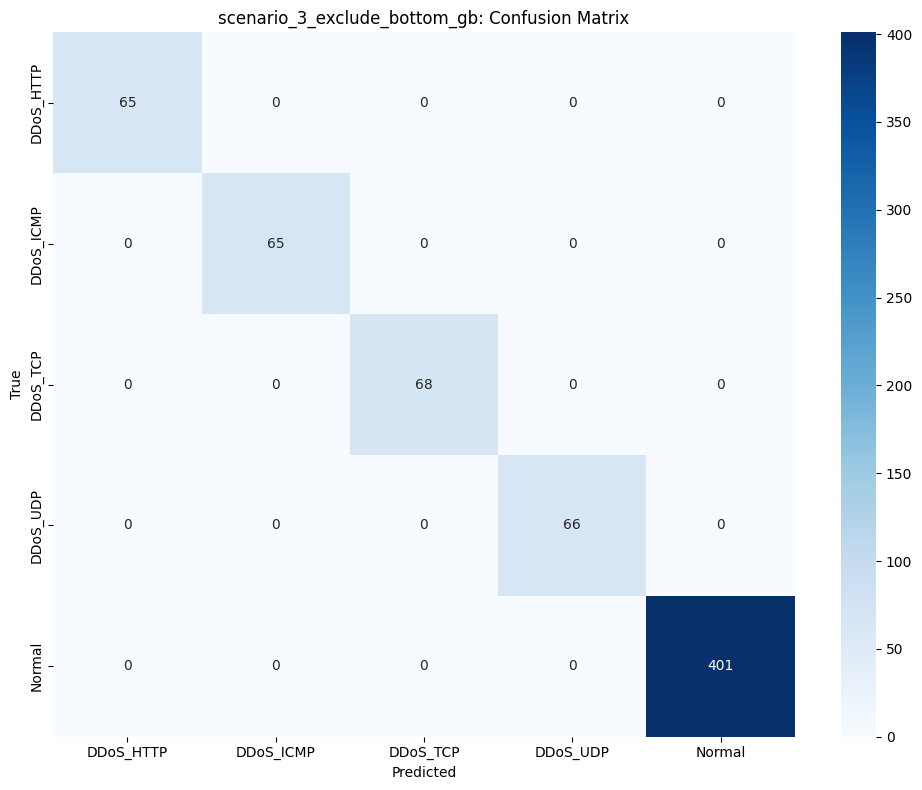


--- DNN (Default Settings) ---
Epoch 1/20 | Train Loss: 0.7811 | Val Loss: 0.0633 | Train Acc: 0.9463 | Val Acc: 0.9925
Epoch 2/20 | Train Loss: 0.3931 | Val Loss: 0.0563 | Train Acc: 0.9674 | Val Acc: 0.9940
Epoch 3/20 | Train Loss: 0.2609 | Val Loss: 0.0411 | Train Acc: 0.9724 | Val Acc: 0.9940
Epoch 4/20 | Train Loss: 0.2191 | Val Loss: 0.0429 | Train Acc: 0.9724 | Val Acc: 0.9940
Epoch 5/20 | Train Loss: 0.2112 | Val Loss: 0.0316 | Train Acc: 0.9764 | Val Acc: 0.9940
Epoch 6/20 | Train Loss: 0.1808 | Val Loss: 0.0323 | Train Acc: 0.9824 | Val Acc: 0.9940
Epoch 7/20 | Train Loss: 0.1387 | Val Loss: 0.0329 | Train Acc: 0.9814 | Val Acc: 0.9940
Epoch 8/20 | Train Loss: 0.0992 | Val Loss: 0.0168 | Train Acc: 0.9829 | Val Acc: 0.9955
Epoch 9/20 | Train Loss: 0.1127 | Val Loss: 0.0176 | Train Acc: 0.9849 | Val Acc: 0.9955
Epoch 10/20 | Train Loss: 0.1576 | Val Loss: 0.0186 | Train Acc: 0.9839 | Val Acc: 0.9940
Epoch 11/20 | Train Loss: 0.0821 | Val Loss: 0.0157 | Train Acc: 0.9844 | Val

<Figure size 640x480 with 0 Axes>

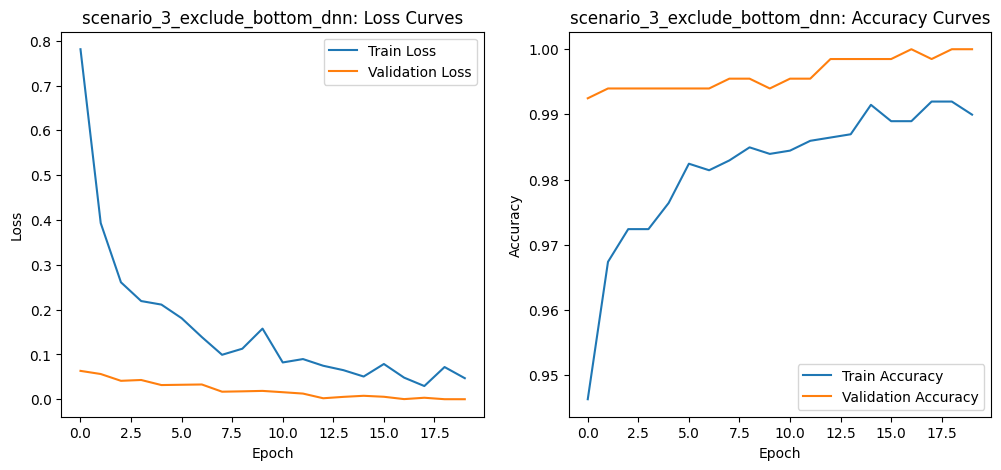

Classification Report:
              precision    recall  f1-score   support

   DDoS_HTTP       1.00      1.00      1.00        65
   DDoS_ICMP       1.00      1.00      1.00        65
    DDoS_TCP       1.00      1.00      1.00        68
    DDoS_UDP       1.00      1.00      1.00        66
      Normal       1.00      1.00      1.00       401

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665



<Figure size 640x480 with 0 Axes>

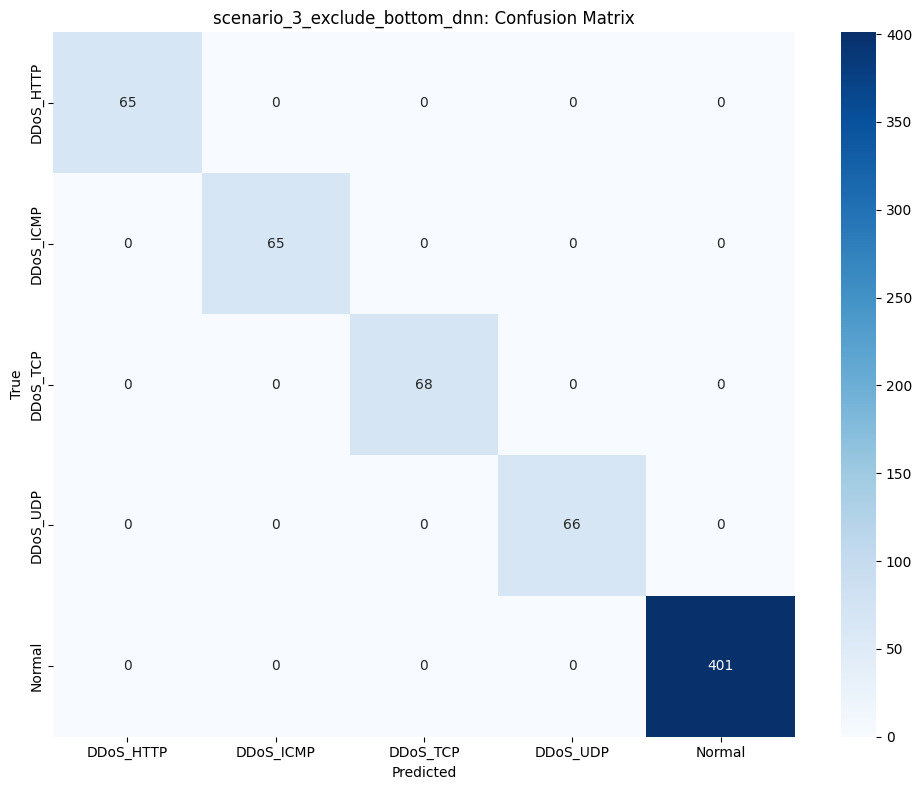

<Figure size 640x480 with 0 Axes>

In [12]:
scenario_3()


--- Scenario 4: Model Architecture & Alternative ML Technique ---

--- Original DNN ---
Epoch 1/20 | Train Loss: 0.4125 | Val Loss: 0.3359 | Train Acc: 0.8850 | Val Acc: 0.8838
Epoch 2/20 | Train Loss: 0.3004 | Val Loss: 0.2421 | Train Acc: 0.8942 | Val Acc: 0.9000
Epoch 3/20 | Train Loss: 0.2496 | Val Loss: 0.2103 | Train Acc: 0.8912 | Val Acc: 0.9087
Epoch 4/20 | Train Loss: 0.2325 | Val Loss: 0.1977 | Train Acc: 0.8962 | Val Acc: 0.9100
Epoch 5/20 | Train Loss: 0.2026 | Val Loss: 0.1820 | Train Acc: 0.9146 | Val Acc: 0.9150
Epoch 6/20 | Train Loss: 0.2398 | Val Loss: 0.1762 | Train Acc: 0.9175 | Val Acc: 0.9187
Epoch 7/20 | Train Loss: 0.2501 | Val Loss: 0.1640 | Train Acc: 0.9150 | Val Acc: 0.9200
Epoch 8/20 | Train Loss: 0.1857 | Val Loss: 0.1644 | Train Acc: 0.9187 | Val Acc: 0.9187
Epoch 9/20 | Train Loss: 0.1951 | Val Loss: 0.1629 | Train Acc: 0.9158 | Val Acc: 0.9200
Epoch 10/20 | Train Loss: 0.1898 | Val Loss: 0.1647 | Train Acc: 0.9179 | Val Acc: 0.9187
Epoch 11/20 | Train 

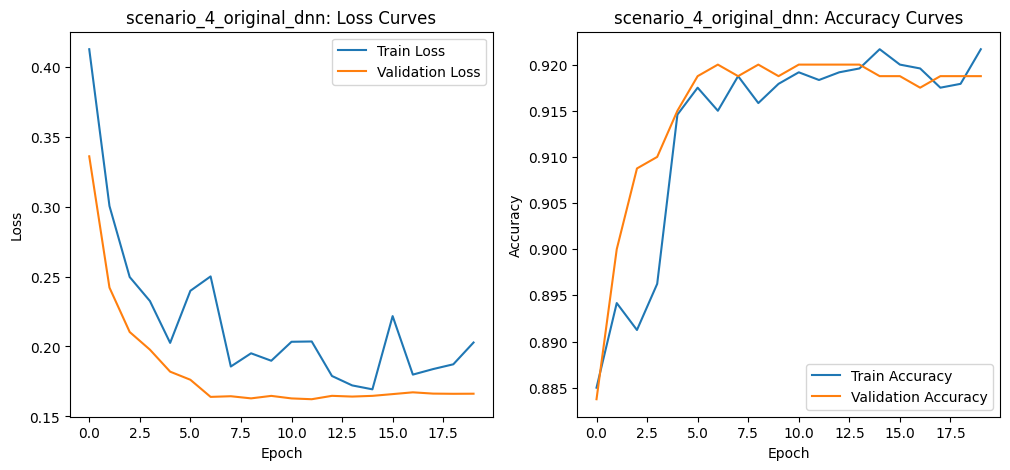

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      1.00      1.00        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       1.00      1.00      1.00        66
               Normal       1.00      1.00      1.00       400
             Password       0.41      1.00      0.58        40
        SQL_injection       1.00      0.04      0.07        28
            Uploading       0.00      0.00      0.00        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.92       800
            macro avg       0.81      0.76      0.72       800
         weighted avg       0.92      0.92      0.90       800



/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

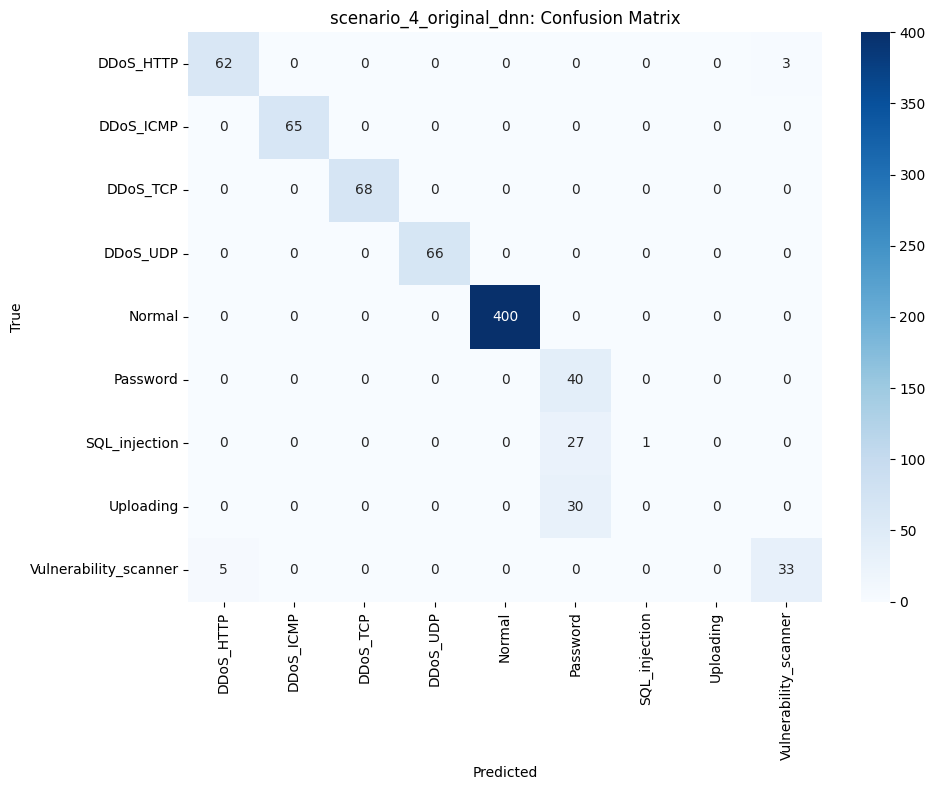


--- Custom DNN ---
Epoch 1/20 | Train Loss: 1.1184 | Val Loss: 0.4561 | Train Acc: 0.7392 | Val Acc: 0.9187
Epoch 2/20 | Train Loss: 0.3215 | Val Loss: 0.2206 | Train Acc: 0.9071 | Val Acc: 0.9087
Epoch 3/20 | Train Loss: 0.2097 | Val Loss: 0.1871 | Train Acc: 0.9158 | Val Acc: 0.9175
Epoch 4/20 | Train Loss: 0.1925 | Val Loss: 0.1904 | Train Acc: 0.9125 | Val Acc: 0.9113
Epoch 5/20 | Train Loss: 0.1806 | Val Loss: 0.1730 | Train Acc: 0.9225 | Val Acc: 0.9200
Epoch 6/20 | Train Loss: 0.1745 | Val Loss: 0.1799 | Train Acc: 0.9221 | Val Acc: 0.9200
Epoch 7/20 | Train Loss: 0.1715 | Val Loss: 0.1732 | Train Acc: 0.9192 | Val Acc: 0.9137
Epoch 8/20 | Train Loss: 0.1677 | Val Loss: 0.1723 | Train Acc: 0.9237 | Val Acc: 0.9187
Epoch 9/20 | Train Loss: 0.1589 | Val Loss: 0.1697 | Train Acc: 0.9287 | Val Acc: 0.9225
Epoch 10/20 | Train Loss: 0.1635 | Val Loss: 0.1718 | Train Acc: 0.9200 | Val Acc: 0.9225
Epoch 11/20 | Train Loss: 0.1575 | Val Loss: 0.1675 | Train Acc: 0.9275 | Val Acc: 0.9225

<Figure size 640x480 with 0 Axes>

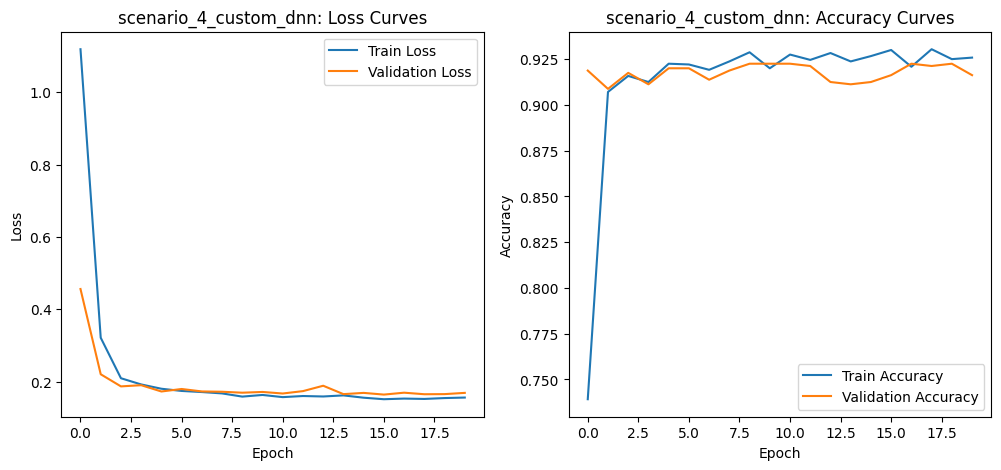

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      0.94      0.97        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       0.94      1.00      0.97        66
               Normal       1.00      1.00      1.00       400
             Password       0.57      0.30      0.39        40
        SQL_injection       0.31      0.71      0.43        28
            Uploading       0.46      0.20      0.28        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.91       800
            macro avg       0.79      0.78      0.76       800
         weighted avg       0.92      0.91      0.91       800



<Figure size 640x480 with 0 Axes>

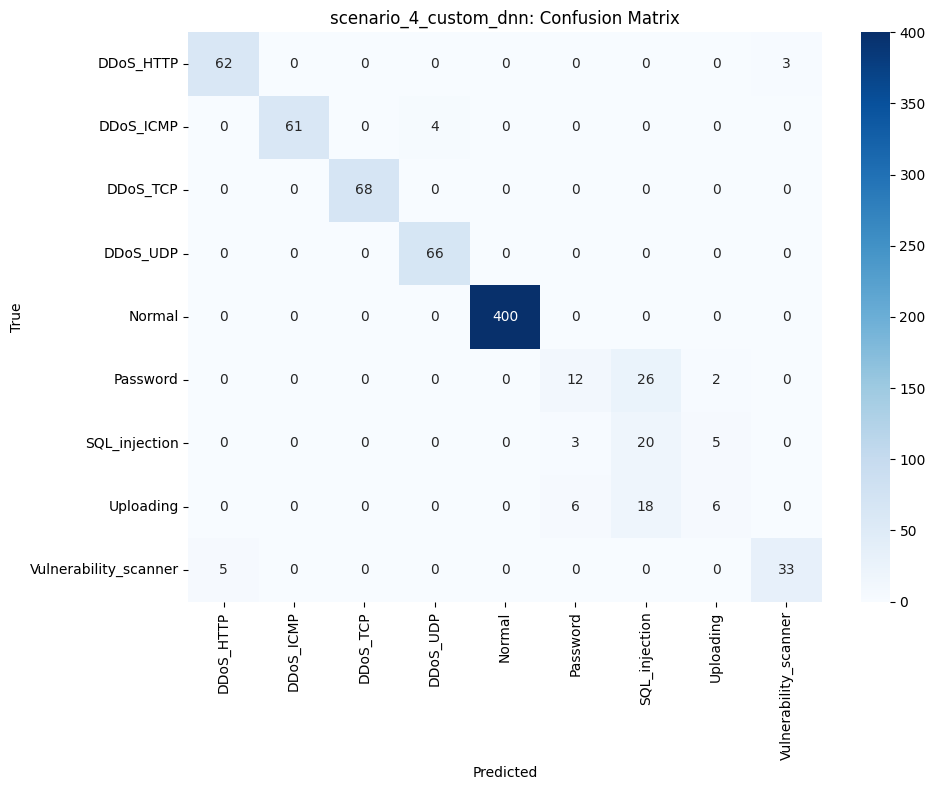


--- Logistic Regression with SGD ---
Epoch 1/20 | Train Acc: 0.8967 | Val Acc: 0.8825
Epoch 2/20 | Train Acc: 0.8979 | Val Acc: 0.8850
Epoch 3/20 | Train Acc: 0.8975 | Val Acc: 0.8838
Epoch 4/20 | Train Acc: 0.9067 | Val Acc: 0.8875
Epoch 5/20 | Train Acc: 0.9154 | Val Acc: 0.9100
Epoch 6/20 | Train Acc: 0.9158 | Val Acc: 0.9100
Epoch 7/20 | Train Acc: 0.9154 | Val Acc: 0.9087
Epoch 8/20 | Train Acc: 0.9175 | Val Acc: 0.9100
Epoch 9/20 | Train Acc: 0.9217 | Val Acc: 0.9113
Epoch 10/20 | Train Acc: 0.9221 | Val Acc: 0.9113


/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before converg

Epoch 11/20 | Train Acc: 0.9225 | Val Acc: 0.9125
Epoch 12/20 | Train Acc: 0.9258 | Val Acc: 0.9113
Epoch 13/20 | Train Acc: 0.9263 | Val Acc: 0.9125
Epoch 14/20 | Train Acc: 0.9263 | Val Acc: 0.9125
Epoch 15/20 | Train Acc: 0.9267 | Val Acc: 0.9137
Epoch 16/20 | Train Acc: 0.9267 | Val Acc: 0.9137
Epoch 17/20 | Train Acc: 0.9267 | Val Acc: 0.9137
Epoch 18/20 | Train Acc: 0.9267 | Val Acc: 0.9150
Epoch 19/20 | Train Acc: 0.9271 | Val Acc: 0.9150
Epoch 20/20 | Train Acc: 0.9271 | Val Acc: 0.9150


/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before converg

<Figure size 640x480 with 0 Axes>

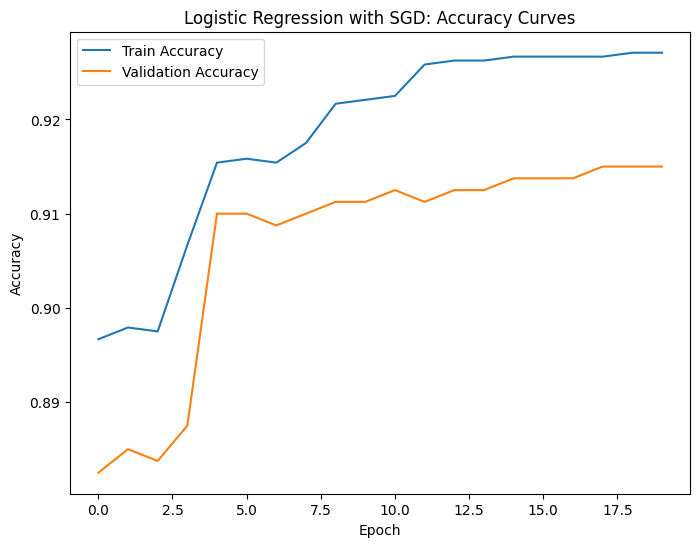

Classification Report:
                       precision    recall  f1-score   support

            DDoS_HTTP       0.93      0.95      0.94        65
            DDoS_ICMP       1.00      0.91      0.95        65
             DDoS_TCP       1.00      1.00      1.00        68
             DDoS_UDP       0.90      1.00      0.95        66
               Normal       1.00      1.00      1.00       400
             Password       0.49      0.95      0.64        40
        SQL_injection       0.57      0.14      0.23        28
            Uploading       0.46      0.20      0.28        30
Vulnerability_scanner       0.92      0.87      0.89        38

             accuracy                           0.92       800
            macro avg       0.81      0.78      0.76       800
         weighted avg       0.92      0.92      0.91       800



<Figure size 640x480 with 0 Axes>

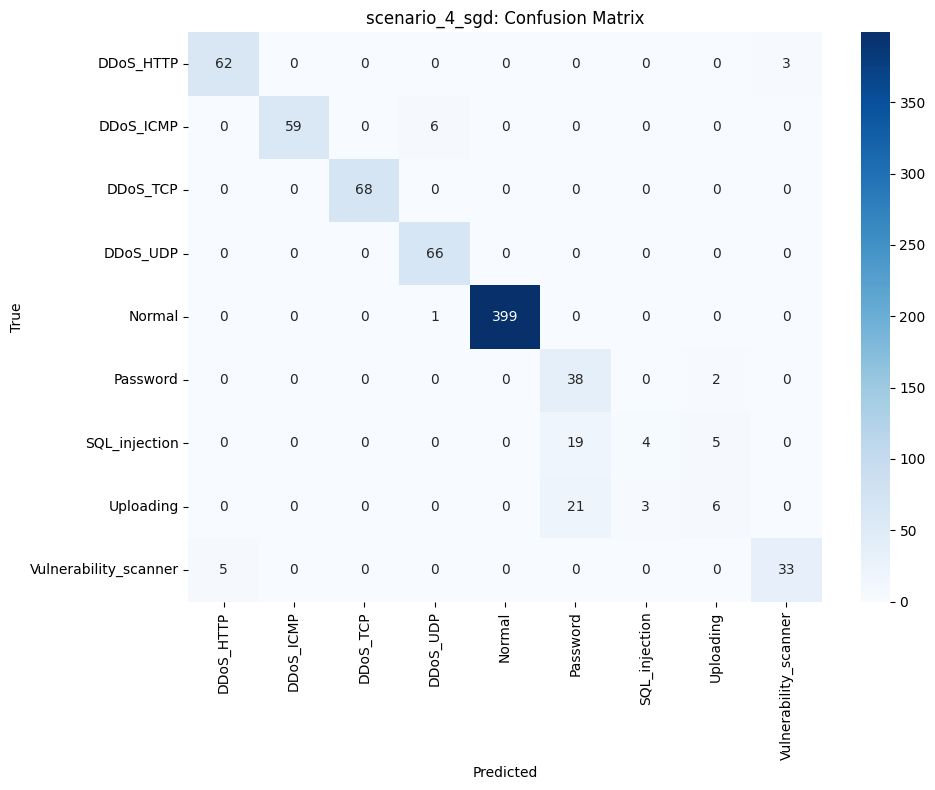

                       Model  Precision (Macro Avg)  Recall (Macro Avg)  \
0               Original DNN               0.806046            0.761998   
1                 Custom DNN               0.792263            0.775002   
2  Logistic Regression (SGD)               0.807366            0.780035   

   F1-Score (Macro Avg)  Accuracy  
0              0.720466   0.91875  
1              0.764158   0.91000  
2              0.764777   0.91875  


/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beanjam/Desktop/SYSC 4906 D/ASGN 2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

<Figure size 640x480 with 0 Axes>

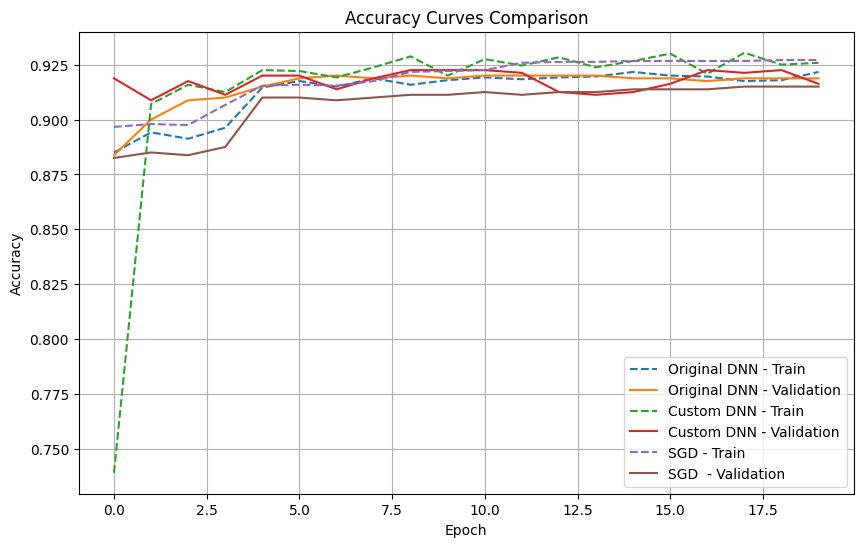

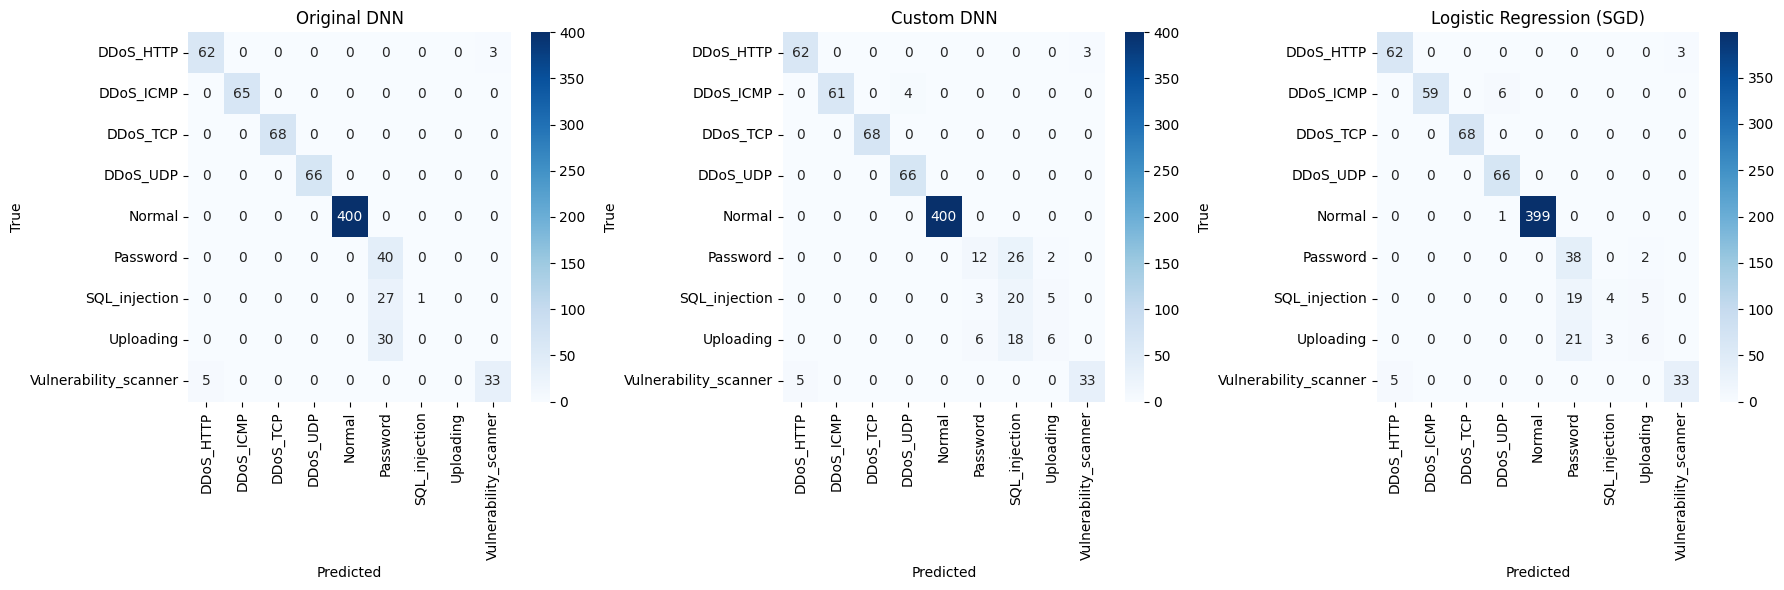

In [13]:
scenario_4()